In [25]:
%load_ext autoreload
%autoreload 2

In [84]:
import os
import ase
import glob
import tqdm
import scipy
import numpy as np
import ase.io as aio
import pandas as pd
import skimage


from toolz.curried import pipe, curry, compose

In [3]:
from sklearn.decomposition import PCA

In [4]:
import plot
import atommks.atomstat as astat
import atommks.helpers as utils

In [11]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


def compute_pca(x_data, n_comp=10, vis=True, labels=None, tag=""):
    
    pca = PCA(n_components=n_comp)
    scores = pca.fit_transform(x_data)

    if vis:
        ex_var = pca.explained_variance_ratio_ * 100
        plt.bar(np.arange(1, n_comp+1), ex_var)
        plt.ylim([0, 100])
        for ix, item in enumerate(ex_var):
            plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
        plt.title("Explained variance plot {}".format(tag))
        plt.grid(b=None)
        plt.show()
        

        if labels is None:
            labels = np.arange(1, len(scores)+1)
            
        plt.scatter(scores[:,0], scores[:,1], c=labels, s=labels)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.grid(b=None)
        plt.title("PC space representation {}".format(tag))
        plt.show()
        
        plt.scatter(scores[:,1], scores[:,2], c=labels, s=labels)
        plt.xlabel("PC 2")
        plt.ylabel("PC 3")
        plt.grid(b=None)
        plt.title("PC space representation {}".format(tag))
        plt.show()
        
    return scores, pca

In [5]:
from ase import Atoms 
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

runs = np.loadtxt("runs.txt").astype(int)

In [6]:
cutoff = 17.0
r_stat = 15.0
len_pixel = 10.0 

r_s = 1.0 # radius of the smoothening filter
width = 0.25 # smoothening for the RDF function

In [7]:
new_shape = np.asarray([int(2 * r_stat * len_pixel + 1) + int(2 * r_s * len_pixel)]*3)

fs = pipe(r_s, 
          lambda r_s: utils.sphere(r_s * len_pixel),
          lambda s: utils.padder(s, new_shape), 
          lambda s: utils.imfilter(f_data1=s, f_data2=s) / np.count_nonzero(s))

smooth_box = compose(lambda s: utils.imfilter(f_data1=s, f_data2=fs), 
                     lambda s: utils.padder(s, new_shape))

smooth_sig = curry(lambda sig, w, bins: utils.convolve_kernel(kernel_arr=utils.epanechnikov_kernel(width=w, 
                                                                                                 x=bins), 
                                                          sig=sig))(w=width)

In [9]:
for run in tqdm.tqdm_notebook(runs):

    f_stat = "data/stats_new_irr/dump.arc.{}_stat.pkl".format(run)
    stat = utils.load_file(f_stat)
    
    rdf_list.append(smooth_sig(bins=stat["bins"])(stat["pdf"]))
    tpt_list.append(smooth_box(stat["box"]))
    n_atoms_irr.append(stat["n_irr"])
    
    print("disturbed atoms: {}".format(n_atoms_irr[-1]))

/storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


disturbed atoms: 0
disturbed atoms: 87589
disturbed atoms: 132505
disturbed atoms: 171079
disturbed atoms: 182610
disturbed atoms: 189780
disturbed atoms: 207399
disturbed atoms: 206487
disturbed atoms: 205043
disturbed atoms: 242254
disturbed atoms: 244316
disturbed atoms: 274957
disturbed atoms: 272163
disturbed atoms: 259587
disturbed atoms: 259220
disturbed atoms: 254992
disturbed atoms: 289464
disturbed atoms: 277355
disturbed atoms: 266384
disturbed atoms: 261720
disturbed atoms: 252704
disturbed atoms: 263228
disturbed atoms: 263316
disturbed atoms: 262055
disturbed atoms: 270915
disturbed atoms: 272846
disturbed atoms: 273242
disturbed atoms: 291440
disturbed atoms: 284804
disturbed atoms: 280123
disturbed atoms: 277256
disturbed atoms: 273150
disturbed atoms: 262331
disturbed atoms: 284864
disturbed atoms: 266712
disturbed atoms: 281529
disturbed atoms: 305358
disturbed atoms: 288660
disturbed atoms: 275626
disturbed atoms: 288960
disturbed atoms: 283293
disturbed atoms: 31096

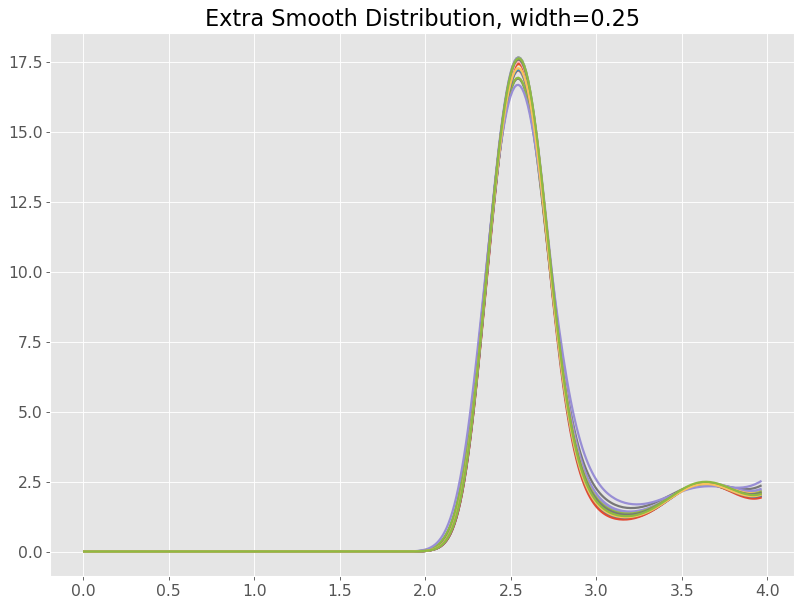

In [125]:
for i in np.random.randint(1, len(rdf_list), 20):
    plt.plot(stat["bins"][:350], rdf_list[i][:350])
plt.title("Extra Smooth Distribution, width=0.25")
plt.show()

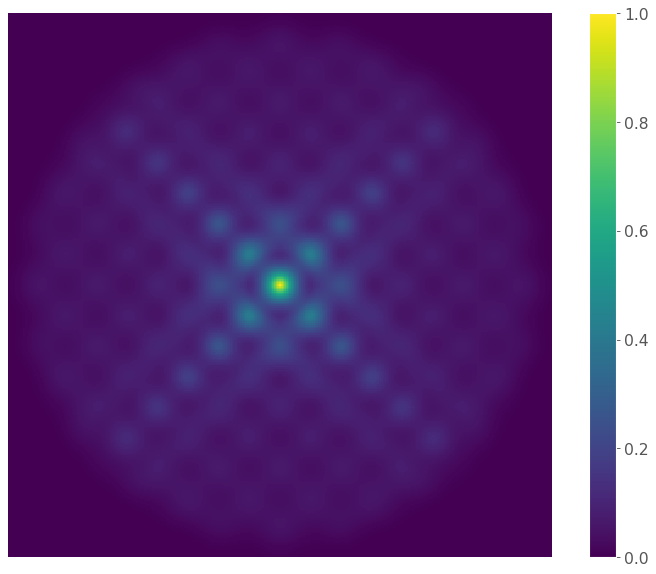

In [13]:
idx = int((r_stat + r_s) * len_pixel)
plot.draw_2d(tpt_list[-10][:,:,idx])

## RDF in PC space

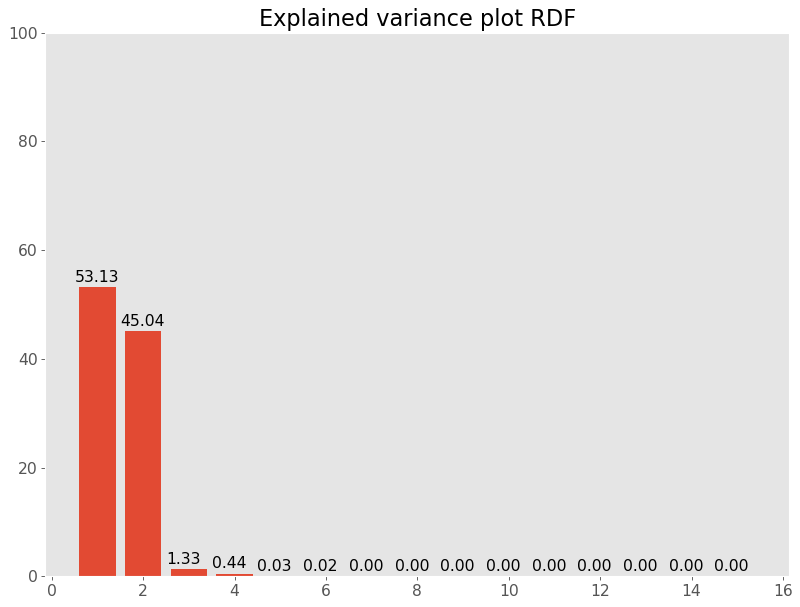

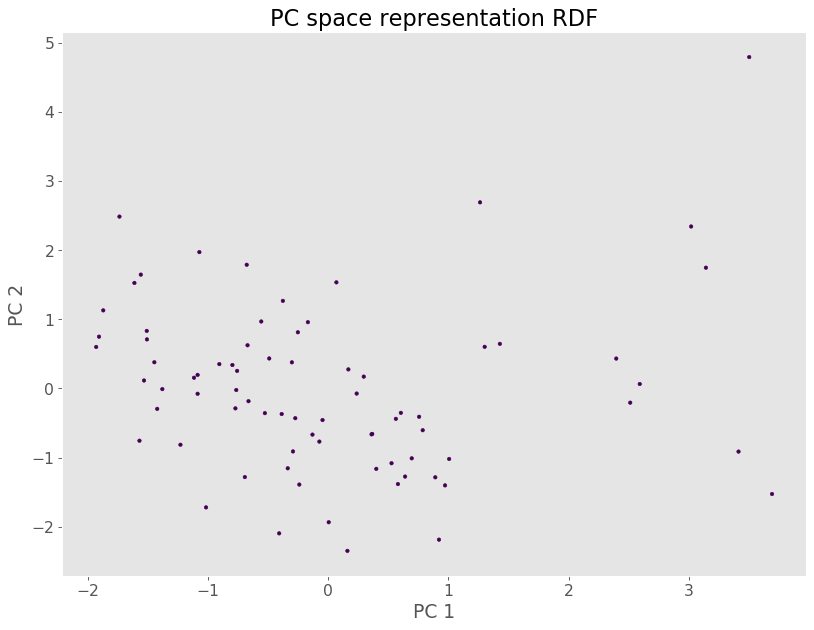

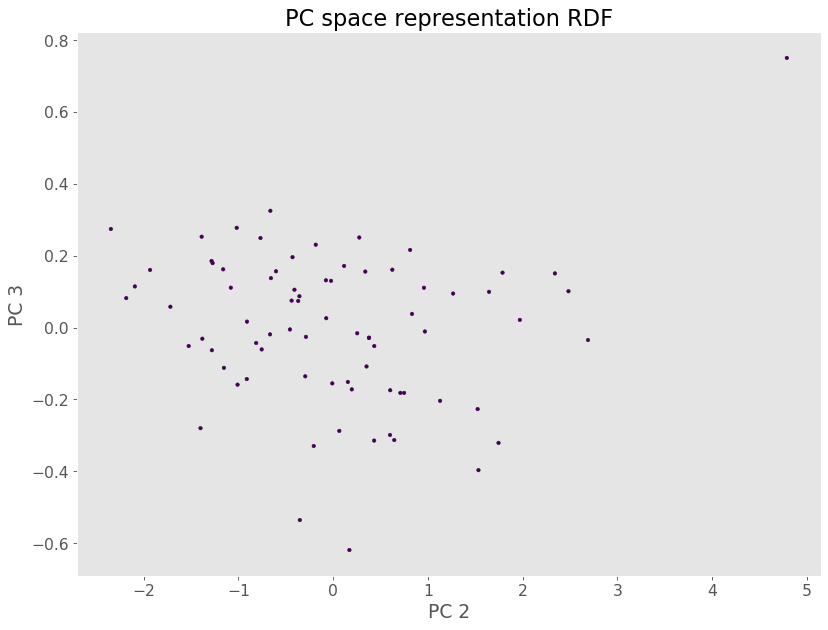

In [131]:
labels = [10]*len(rdf_list)
labels[0] = 100

x_data_rdf = np.concatenate([item[:300][None] for item in rdf_list], axis=0)
scores_rdf, pca_rdf = compute_pca(x_data_rdf[1:], n_comp=15, tag="RDF", labels=labels[1:])

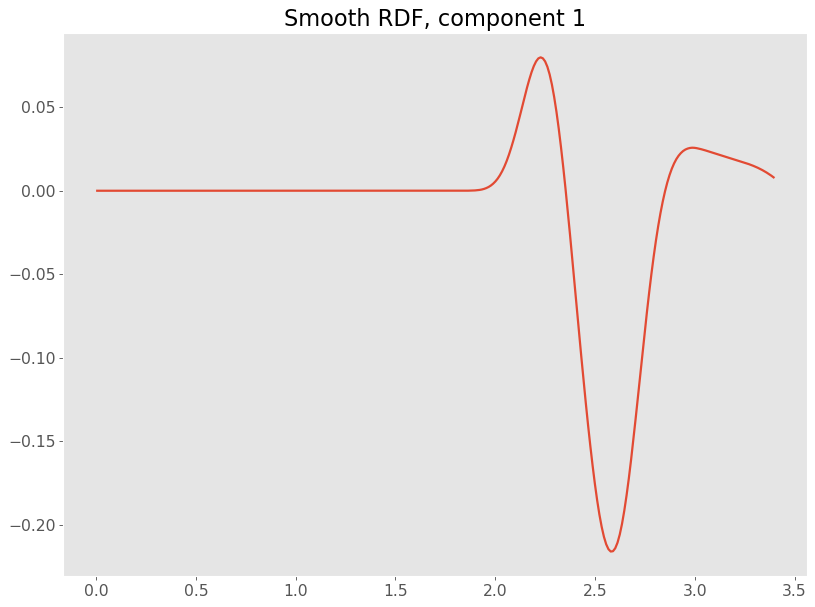

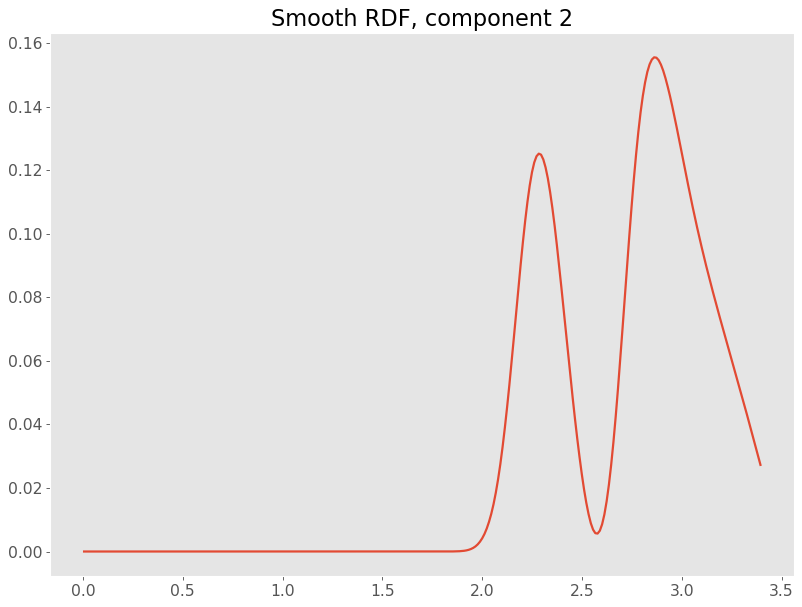

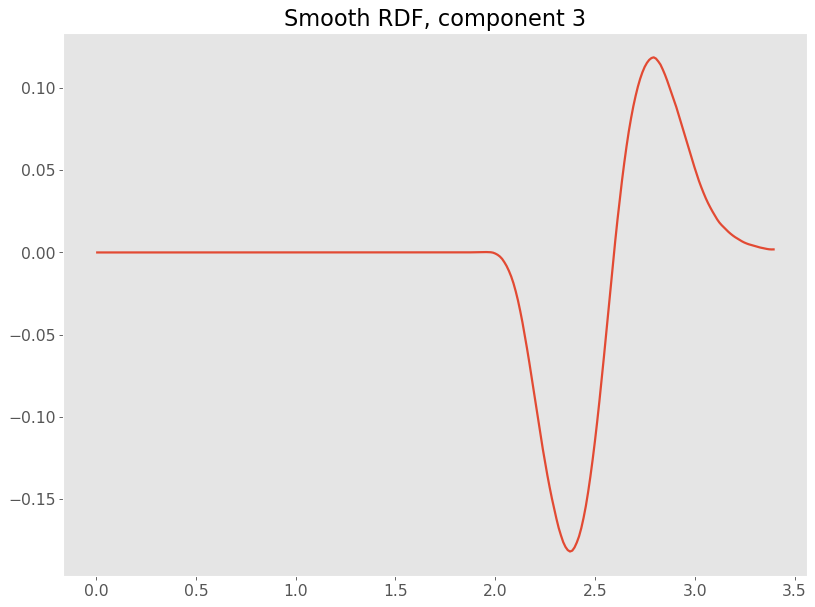

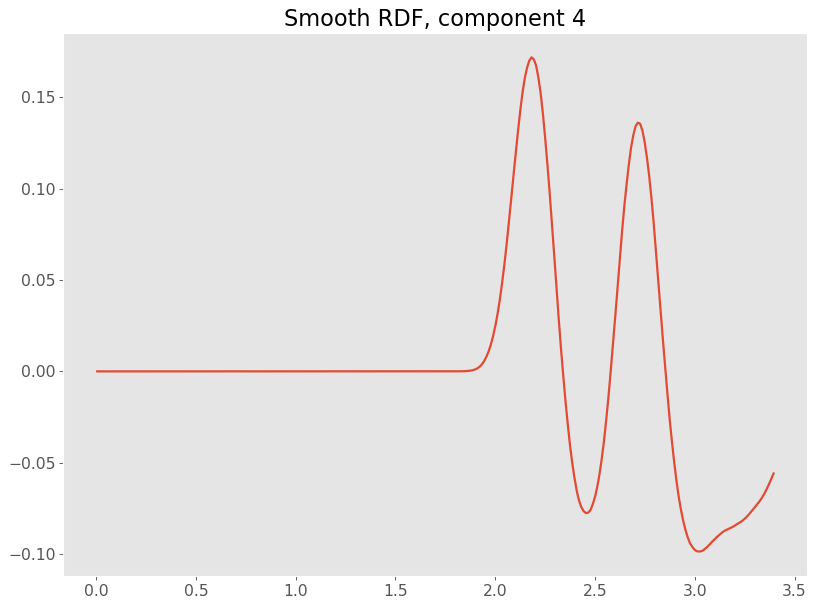

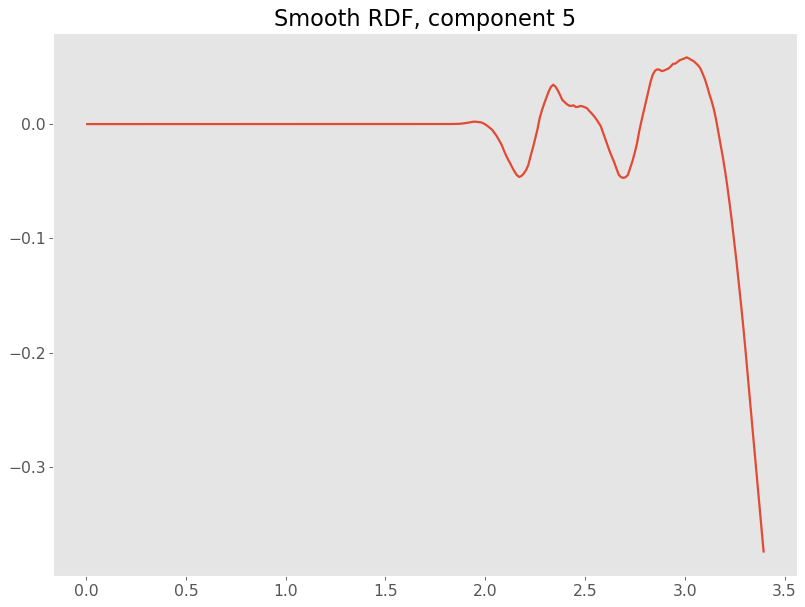

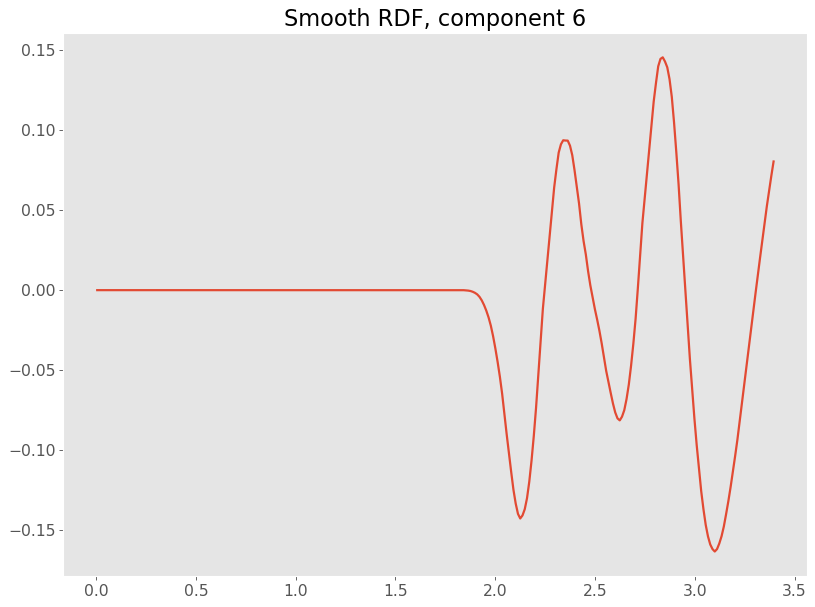

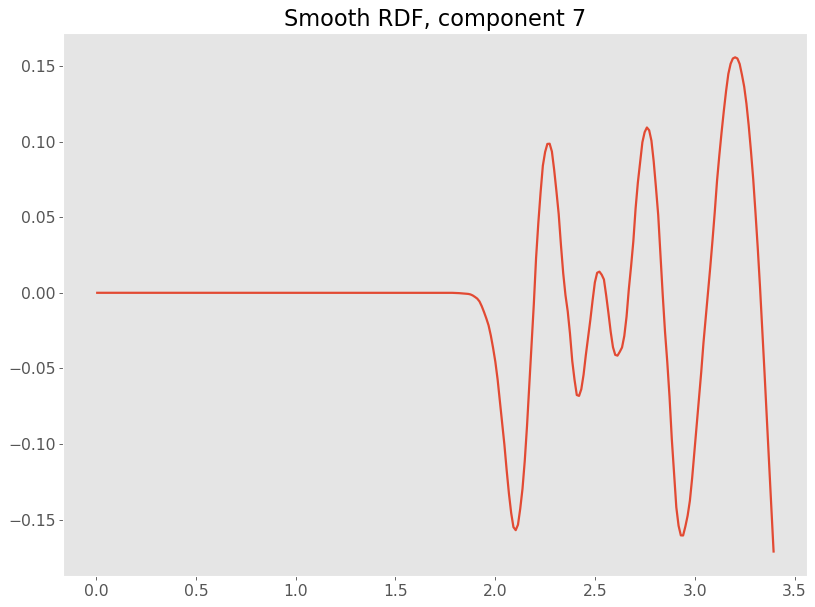

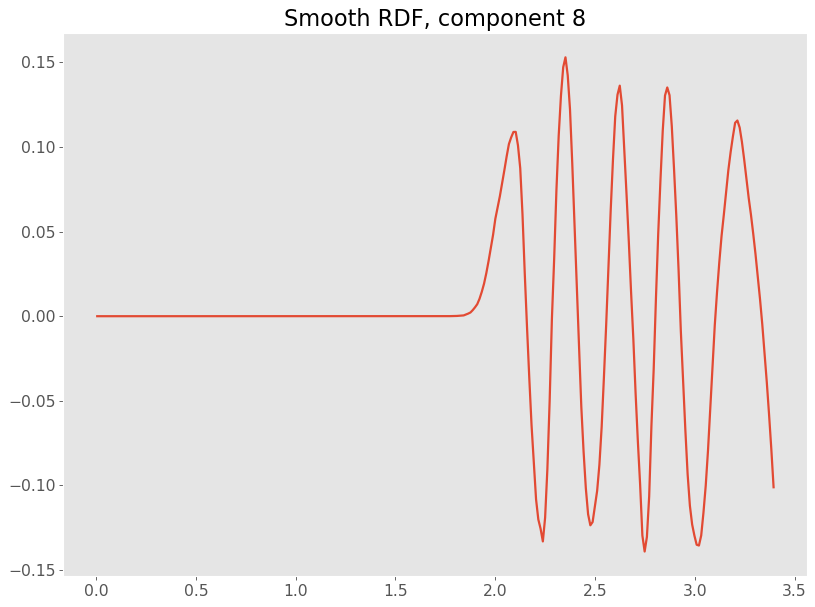

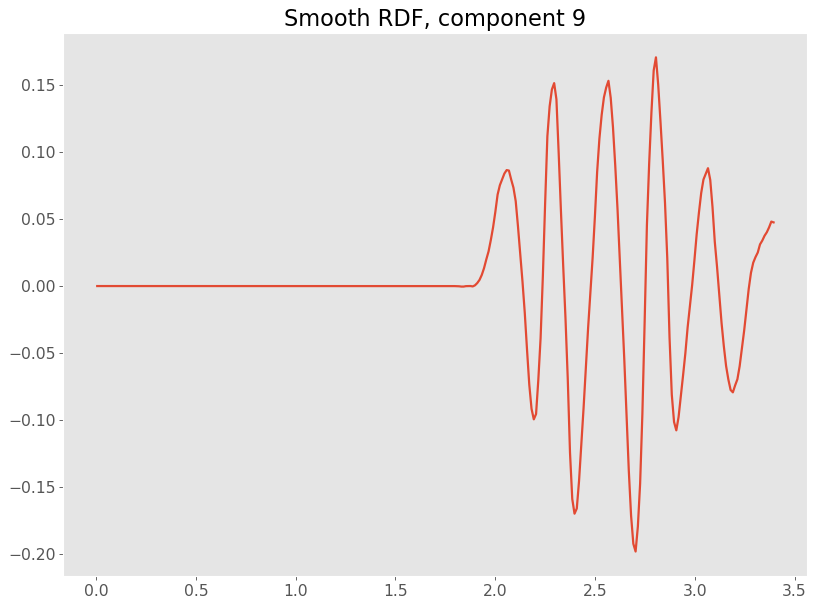

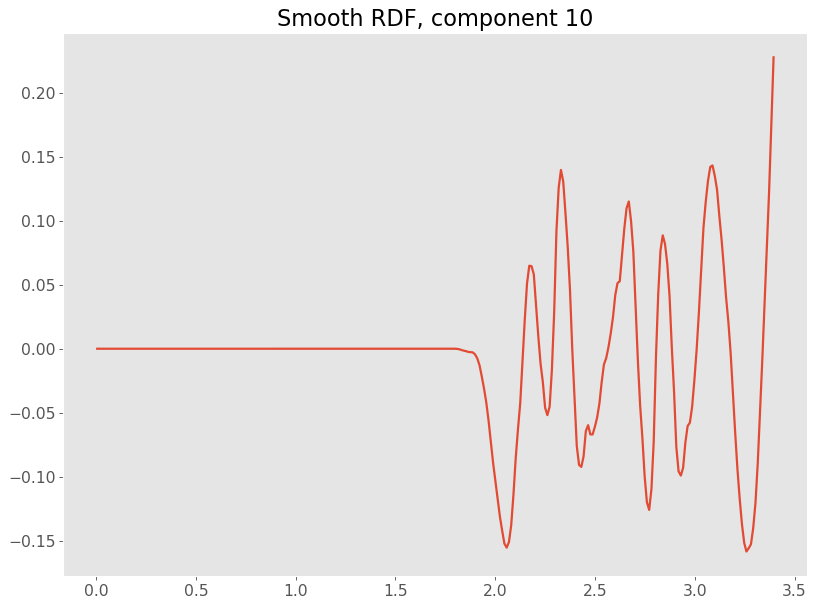

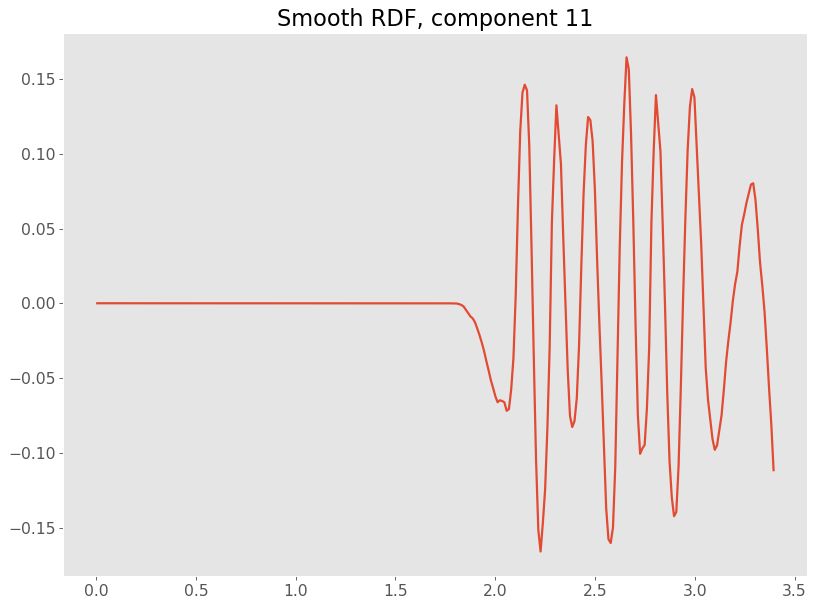

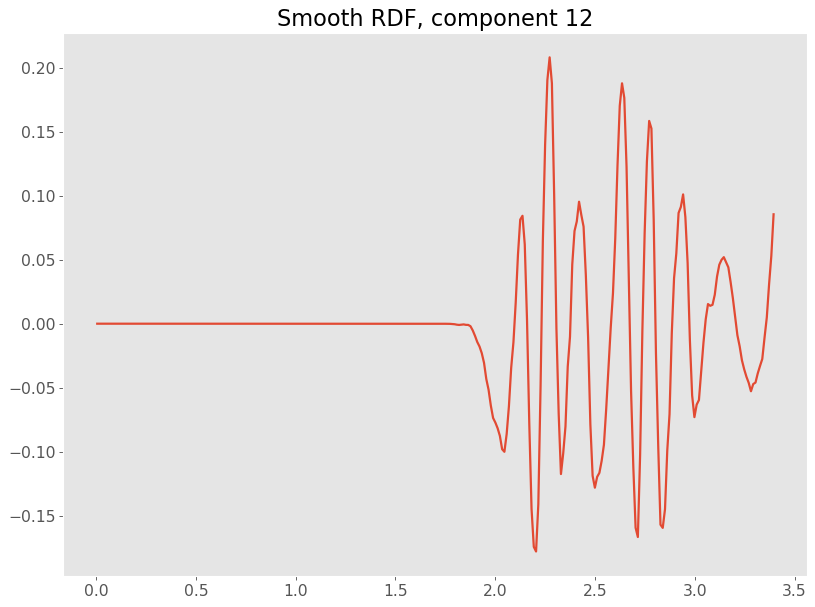

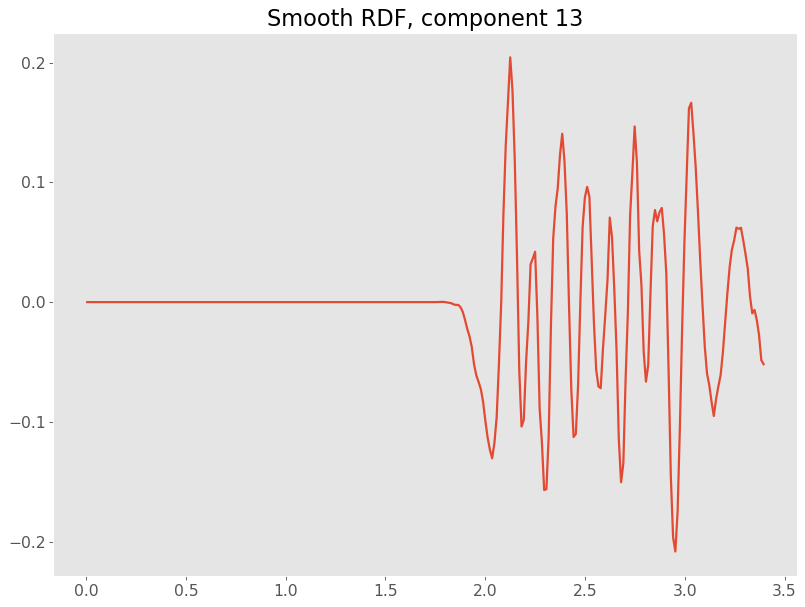

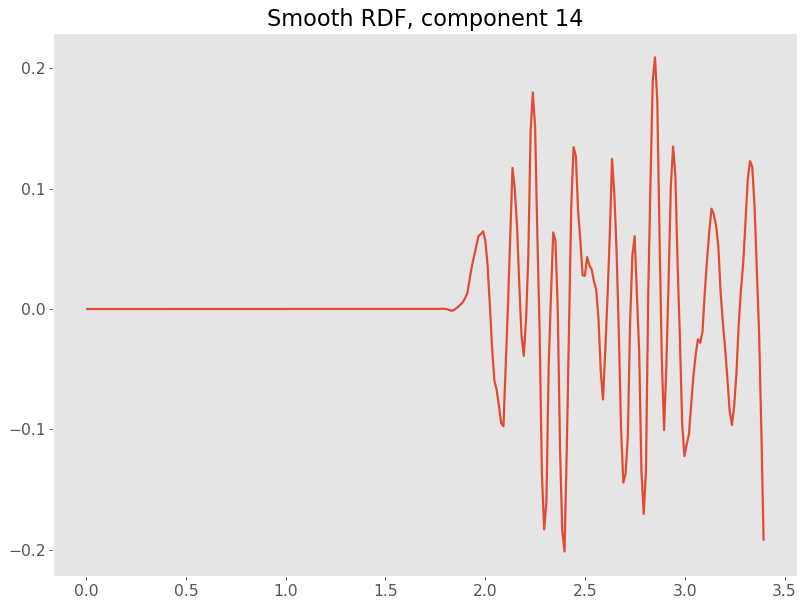

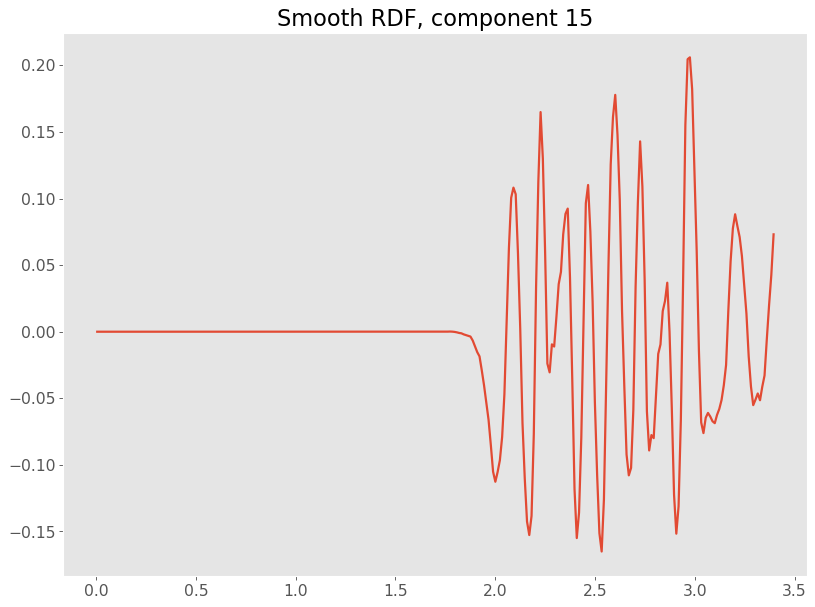

In [202]:
comp_rdf = pca_rdf.components_
for i in range(15):
    plt.plot(stat["bins"][:300], comp_rdf[i])
    plt.title("Smooth RDF, component {}".format(i+1))
    plt.grid(False)
    plt.show()

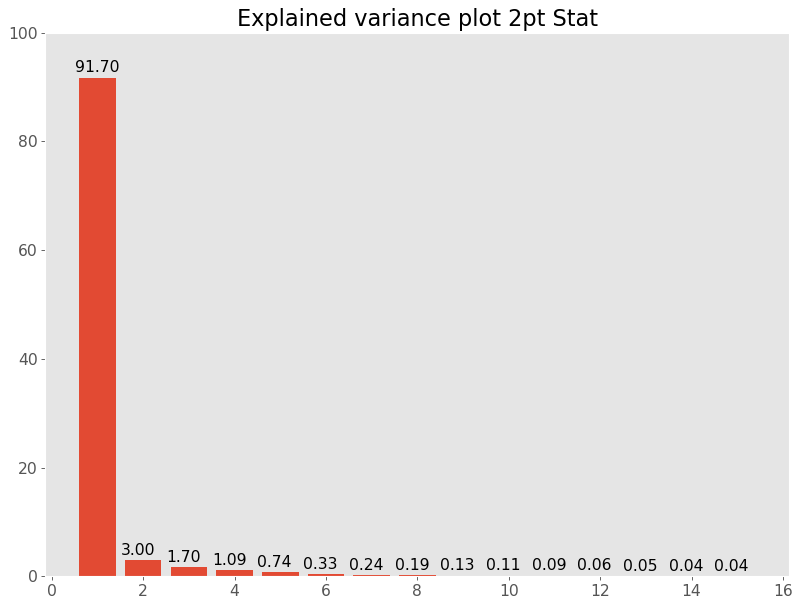

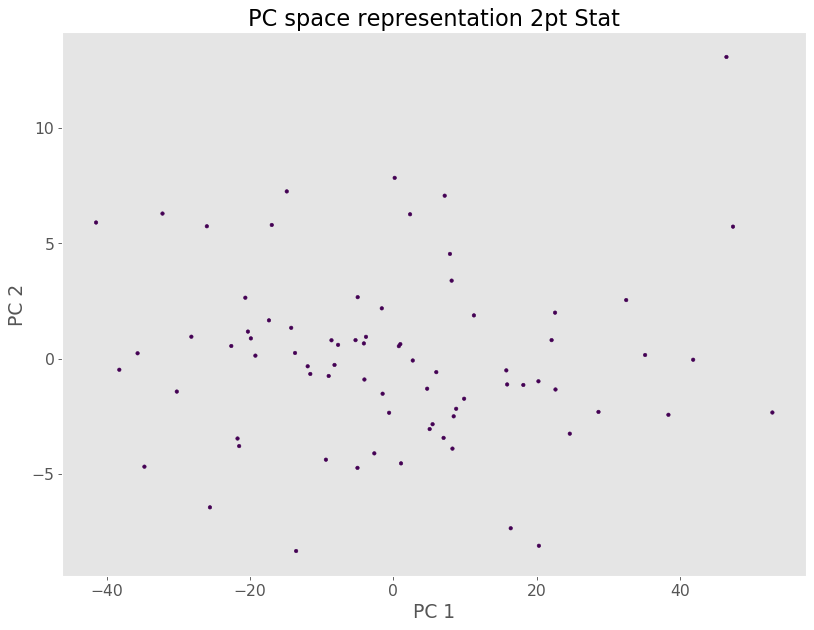

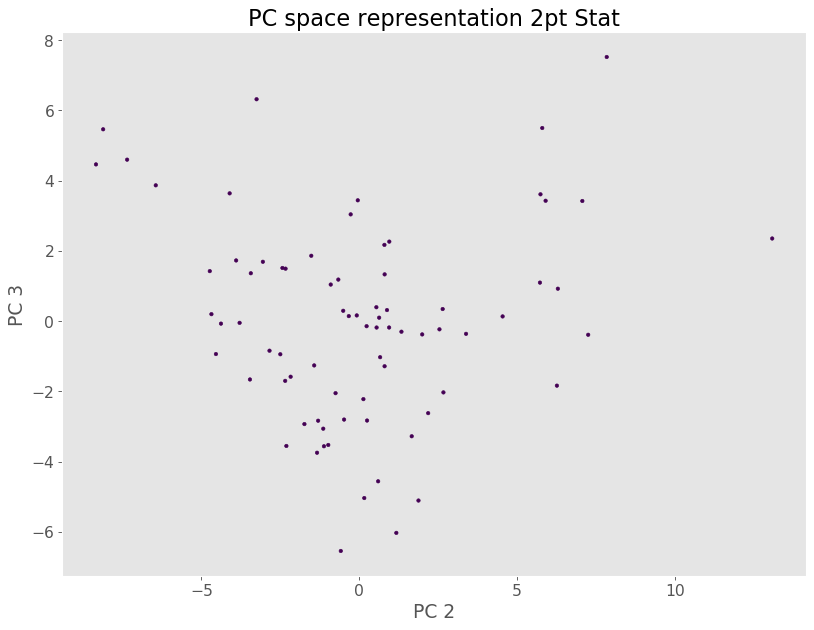

CPU times: user 12min 16s, sys: 59.2 s, total: 13min 15s
Wall time: 3min 10s


In [15]:
%%time
labels = [10]*len(rdf_list)
labels[0] = 100

x_data_tpt = np.concatenate([np.ravel(item)[None] for item in tpt_list], axis=0)
scores_tpt, pca_tpt = compute_pca(x_data_tpt[1:], n_comp=15, tag="2pt Stat", labels=labels[1:])

## Correlation with SAED

In [213]:
img_saed_h = pipe("data/saed_masked_imgs_hid.pkl", 
                  utils.load_file,
                  lambda lst: [np.ravel(x)[None] for x in lst], 
                  curry(np.concatenate)(axis=0))

img_saed_c = pipe("data/saed_masked_imgs.pkl", 
                  utils.load_file,
                  lambda lst: [np.ravel(x)[None] for x in lst], 
                  curry(np.concatenate)(axis=0))

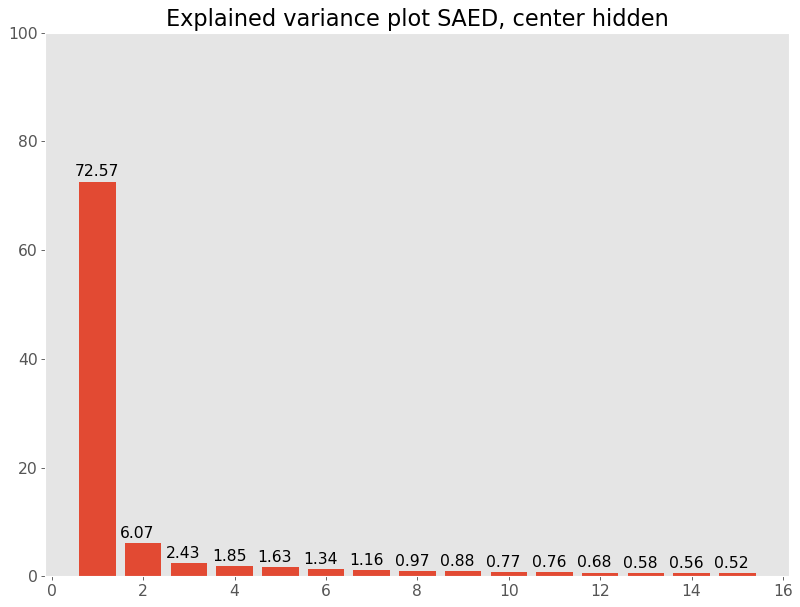

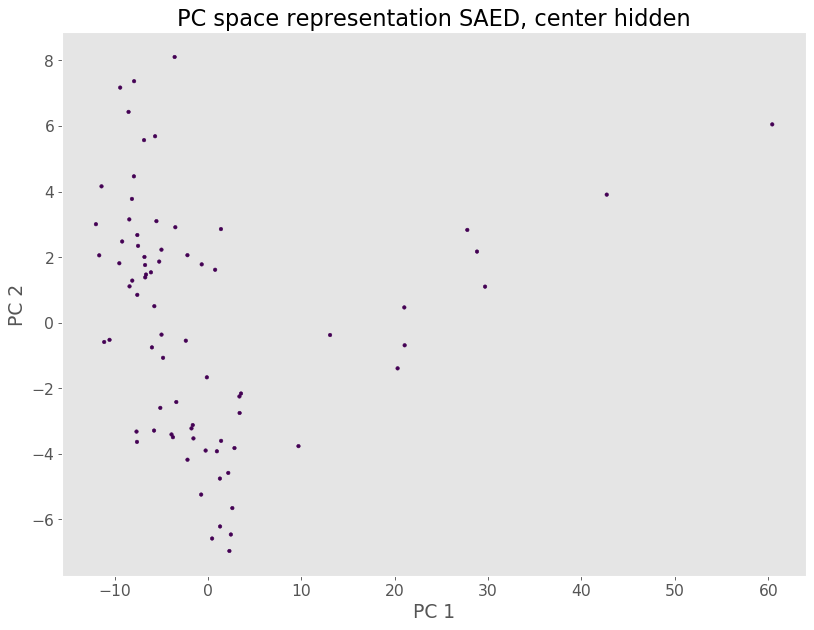

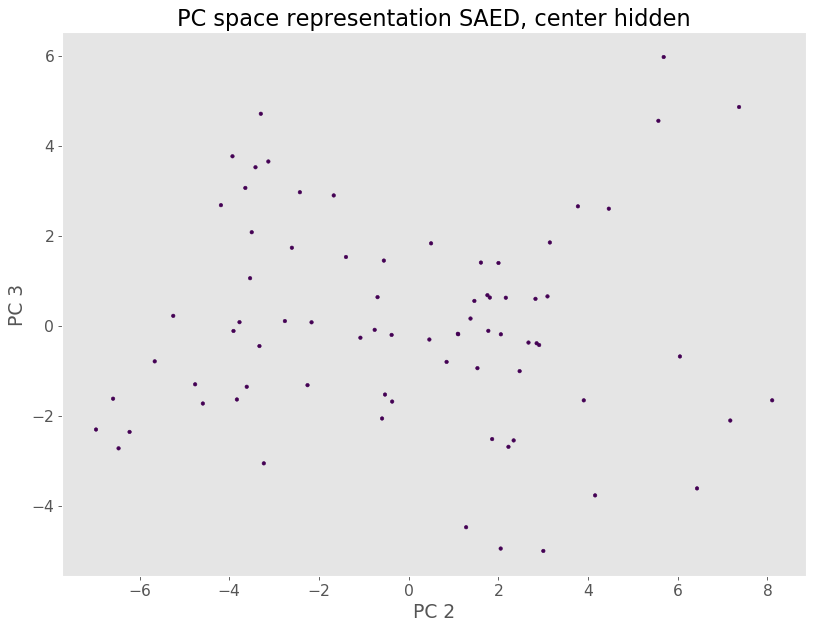

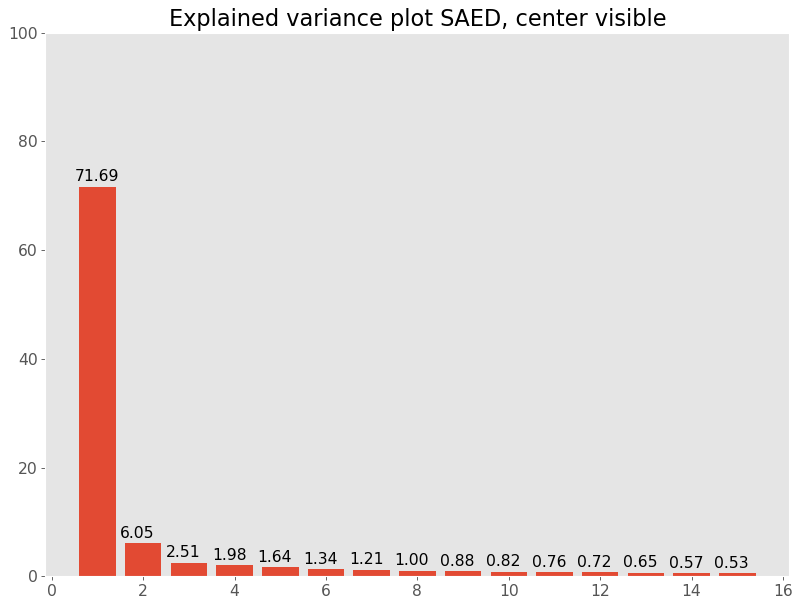

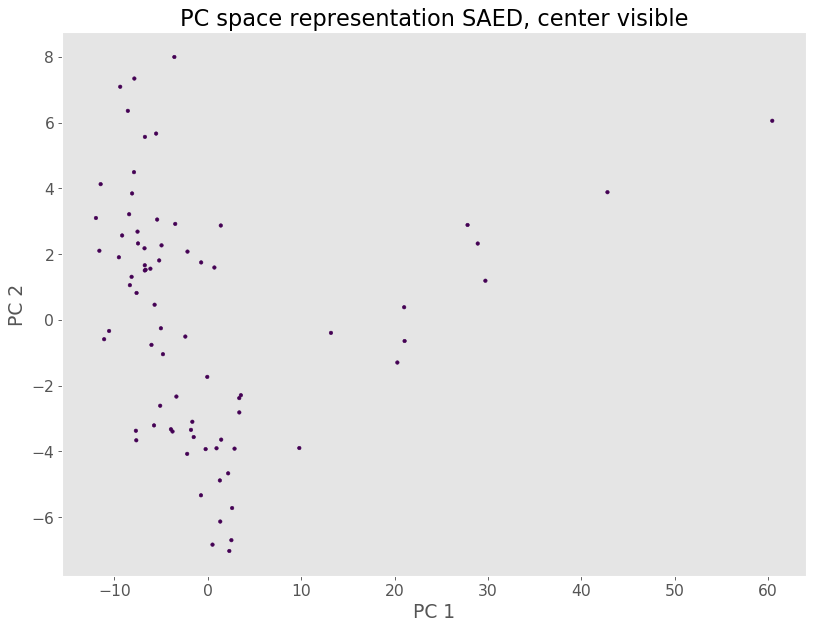

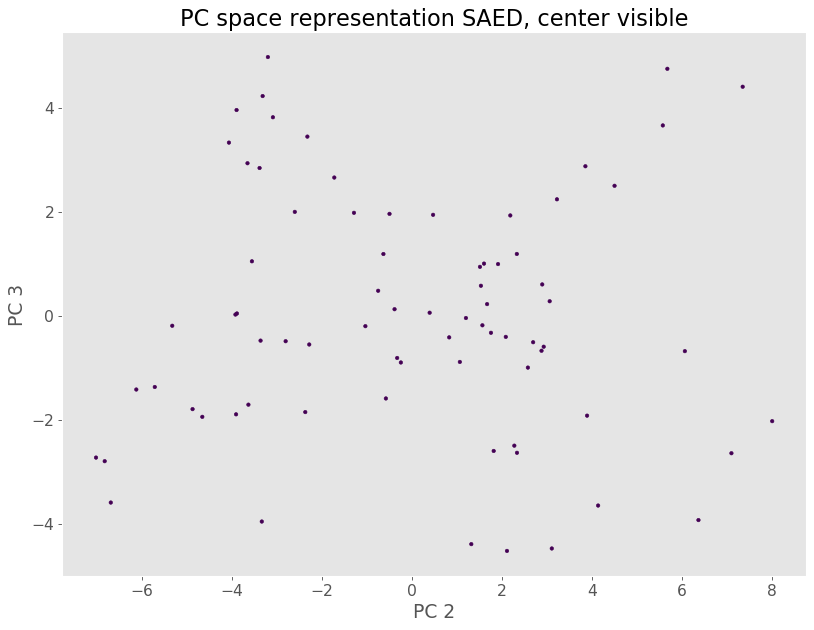

In [214]:
ix = 1
scores_saed_h, pca_saed_h = compute_pca(img_saed_h[ix:], n_comp=15, tag="SAED, center hidden", labels=labels[ix:])
scores_saed_c, pca_saed_c = compute_pca(img_saed_c[ix:], n_comp=15, tag="SAED, center visible", labels=labels[ix:])

In [44]:
run = runs[-1]
d = utils.load_file("data/grids/dump.arc.{}_grid.pkl".format(run))
props = skimage.measure.regionprops(d["lbl"])

In [45]:
n_cluster = len(props)
vols = [prop.area for prop in props]
centroids = np.concatenate([np.array(prop.centroid)[None] for prop in props], axis=0)

In [171]:
v_tot = []
v_mean = []
v_std = []
n_clstr = []
m_x = []
m_y = []
m_z = []

nn_1mean = []
nn_1std = []

nn_2mean = []
nn_2std = []

stats = []

for run in tqdm.tqdm_notebook(runs[1:]):

    d = utils.load_file("data/grids/dump.arc.{}_grid.pkl".format(run))
    props = skimage.measure.regionprops(d["lbl"])

    n_cluster = len(props)
    vols = [prop.area for prop in props]
    centroids = np.concatenate([np.array(prop.centroid)[None] for prop in props], axis=0)
    
    tree = scipy.spatial.cKDTree(centroids)
    dlist = [tree.query(cx, 2)[0][1] for cx in centroids]
    nn_1mean.append(np.mean(dlist))
    nn_1std.append(np.std(dlist))
    
    dlist = [tree.query(cx, 3)[0][-1] for cx in centroids]
    nn_2mean.append(np.mean(dlist))
    nn_2std.append(np.std(dlist))
    
    moments = scipy.stats.moment(centroids, 2, 0)
    
    v_tot.append(np.sum(vols))
    v_mean.append(np.mean(vols))
    v_std.append(np.std(vols))
    n_clstr.append(len(props))
    m_x.append(moments[0])
    m_y.append(moments[1])
    m_z.append(moments[2])
    
    stats.append(np.ravel(d["gg"])[None])

In [80]:
def plot_corrs(x, y, title=""):
    corrs = []
    N = x.shape[1]
    N = 5
    for ix in range(N):
        corrs.append(np.fabs(np.corrcoef(x[:,ix], y)[0,1]))
        
    plt.bar(np.arange(N), corrs)
    
    for ix, item in enumerate(corrs):
        plt.text(ix-0.25, 1.0 - 0.01 * ix, "{:1.2f}".format(item))
    
    plt.ylim([0.0, 1.1])
    plt.title(title)
    plt.grid(False)
    plt.show()

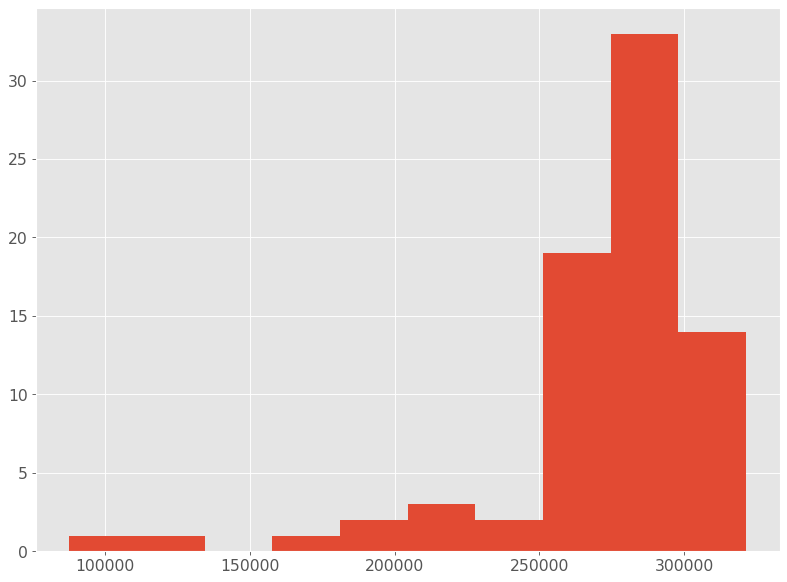

In [172]:
plt.hist(n_atoms_irr[1:])
plt.show()

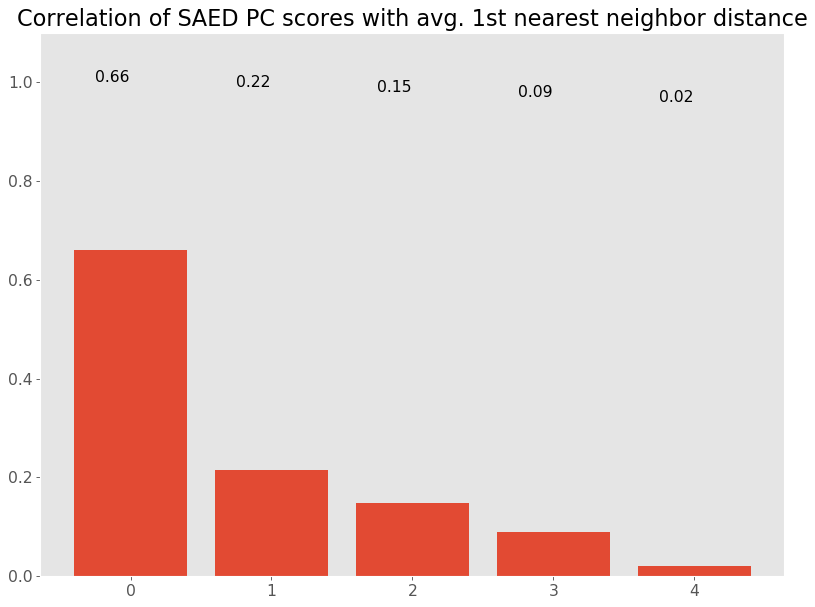

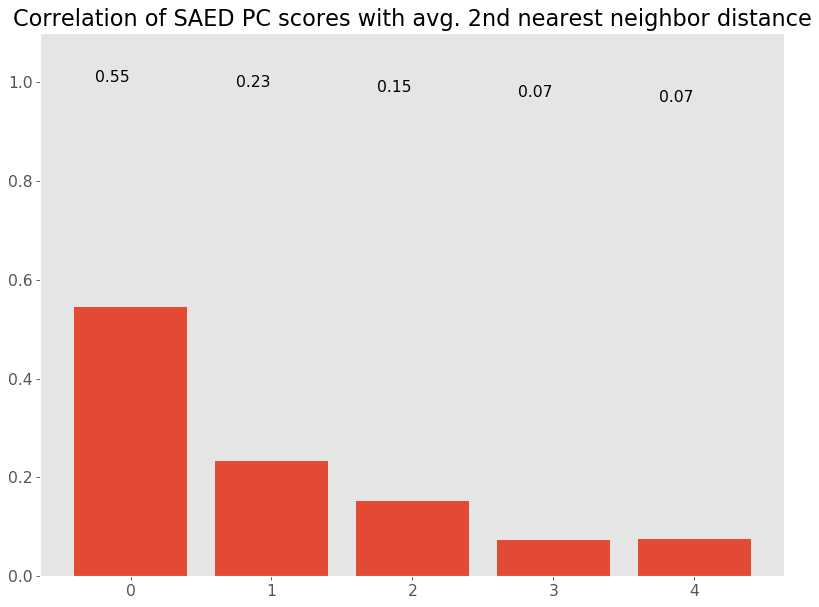

In [215]:
plot_corrs(x=scores_saed_h, y=nn_1mean, 
           title="Correlation of SAED PC scores with avg. 1st nearest neighbor distance")

plot_corrs(x=scores_saed_h, y=nn_2mean, 
           title="Correlation of SAED PC scores with avg. 2nd nearest neighbor distance")

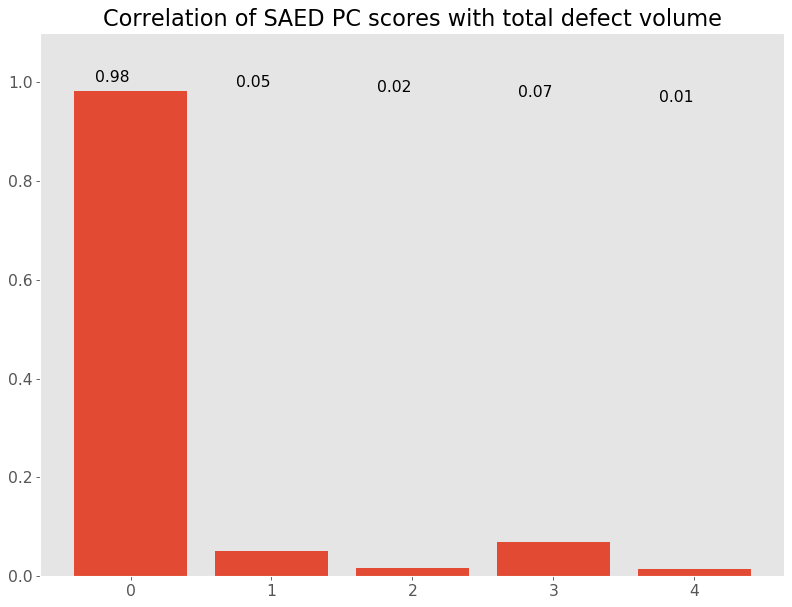

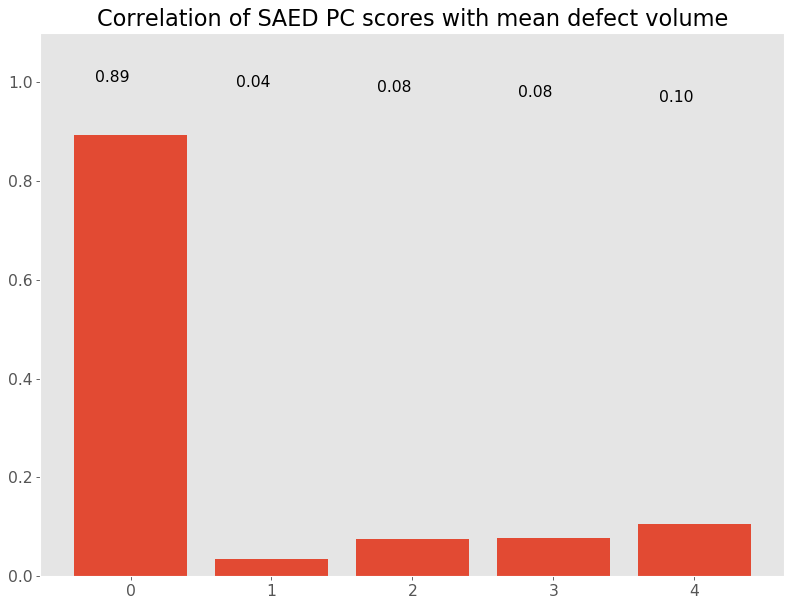

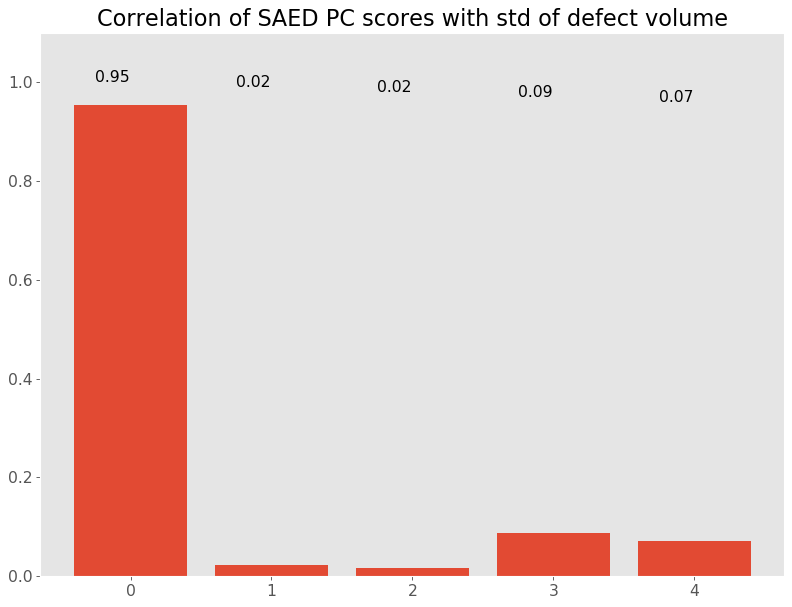

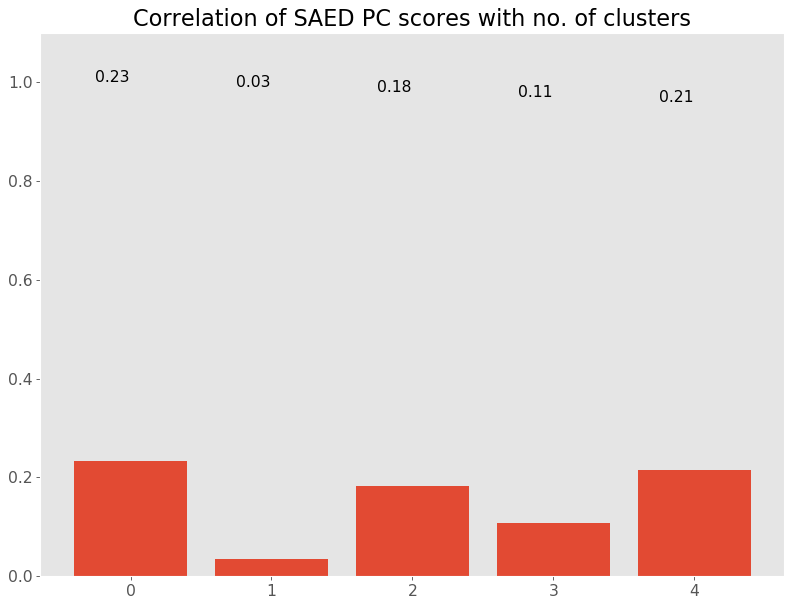

In [153]:
plot_corrs(x=scores_saed_h, y=v_tot, 
           title="Correlation of SAED PC scores with total defect volume")

plot_corrs(x=scores_saed_h, y=v_mean, 
           title="Correlation of SAED PC scores with mean defect volume")

plot_corrs(x=scores_saed_h, y=v_std, 
           title="Correlation of SAED PC scores with std of defect volume")

plot_corrs(x=scores_saed_h, y=n_clstr, 
           title="Correlation of SAED PC scores with no. of clusters")

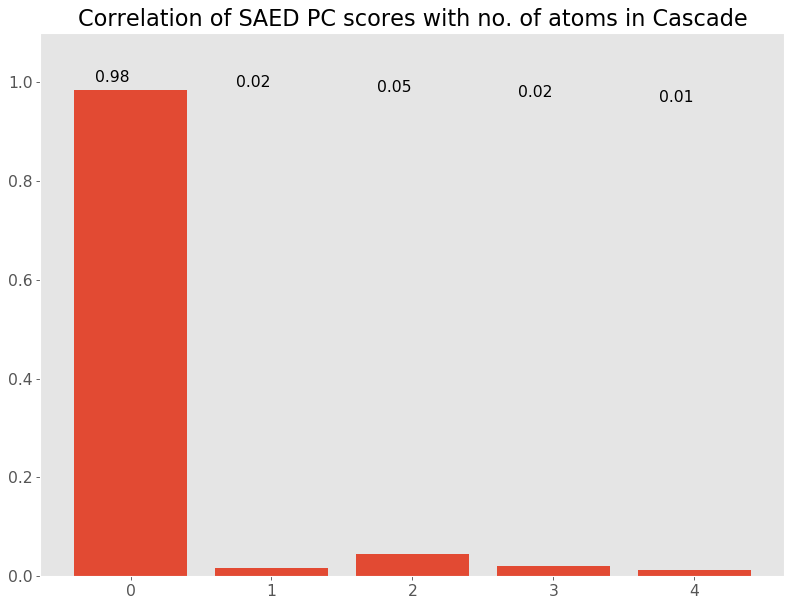

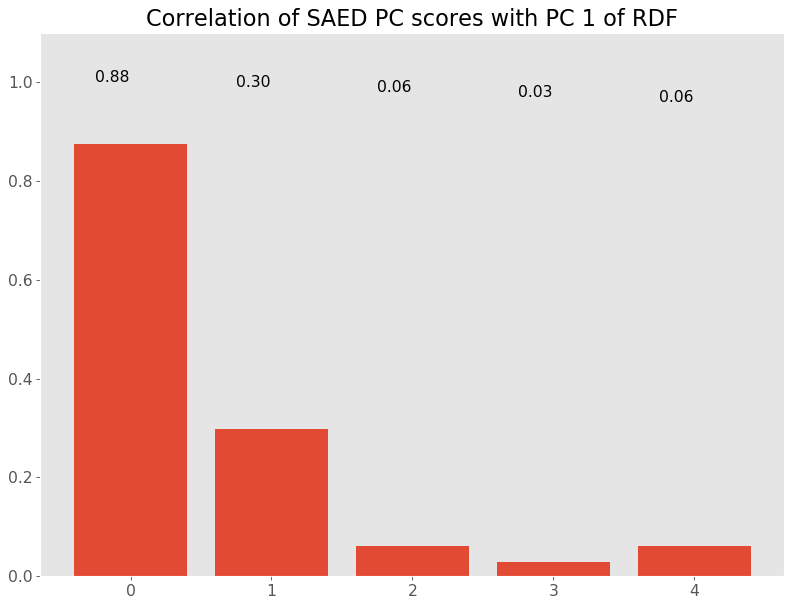

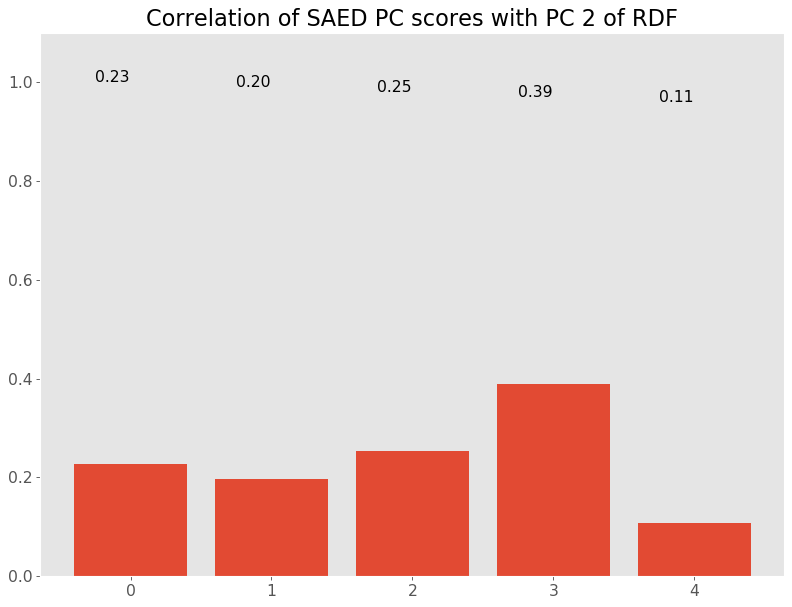

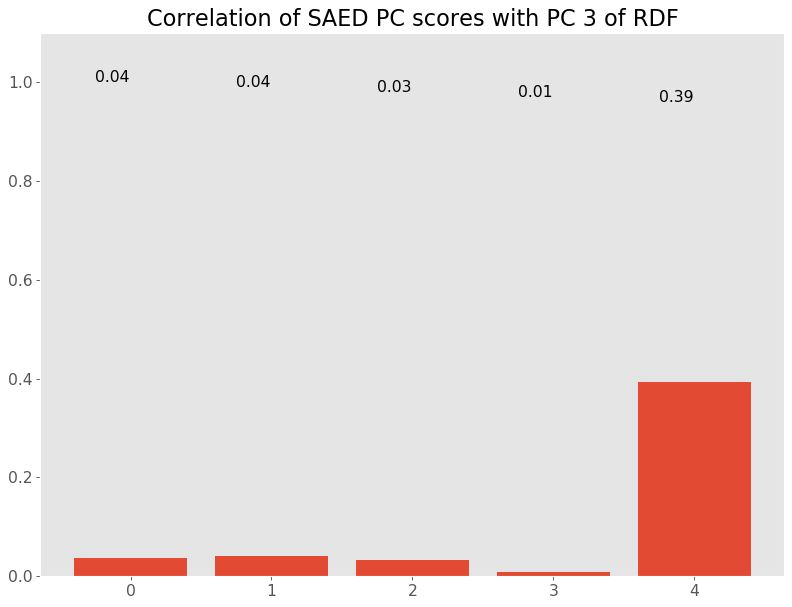

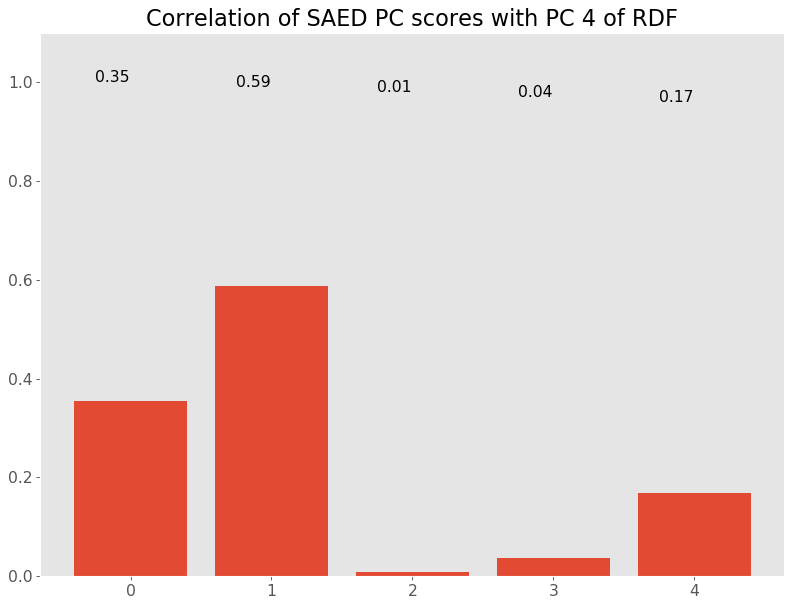

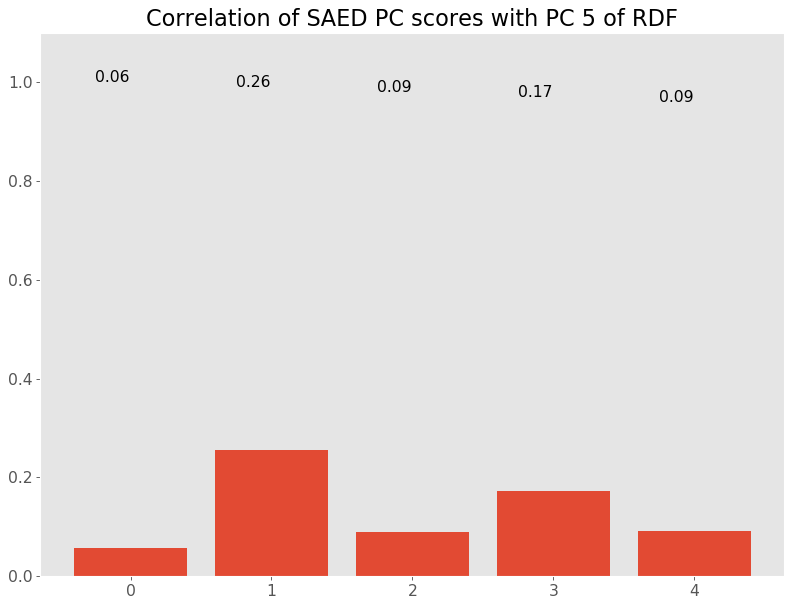

In [203]:
plot_corrs(x=scores_saed_h, y=n_atoms_irr[1:], 
           title="Correlation of SAED PC scores with no. of atoms in Cascade")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,0], 
           title="Correlation of SAED PC scores with PC 1 of RDF")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,1], 
           title="Correlation of SAED PC scores with PC 2 of RDF")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,2], 
           title="Correlation of SAED PC scores with PC 3 of RDF")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,3], 
           title="Correlation of SAED PC scores with PC 4 of RDF")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,4], 
           title="Correlation of SAED PC scores with PC 5 of RDF")

# plot_corrs(x=scores_saed_h, y=scores_tpt[:,0], 
#            title="Correlation of SAED PC scores with PC 1 of 2ptStat")

# plot_corrs(x=scores_saed_h, y=scores_tpt[:,1], 
#            title="Correlation of SAED PC scores with PC 2 of 2ptStat")

# plot_corrs(x=scores_saed_h, y=scores_tpt[:,2], 
#            title="Correlation of SAED PC scores with PC 3 of 2ptStat")

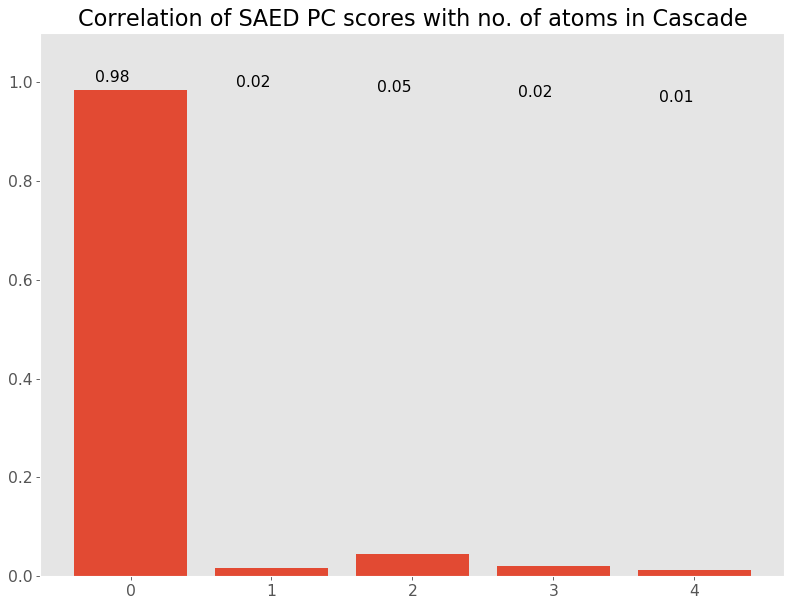

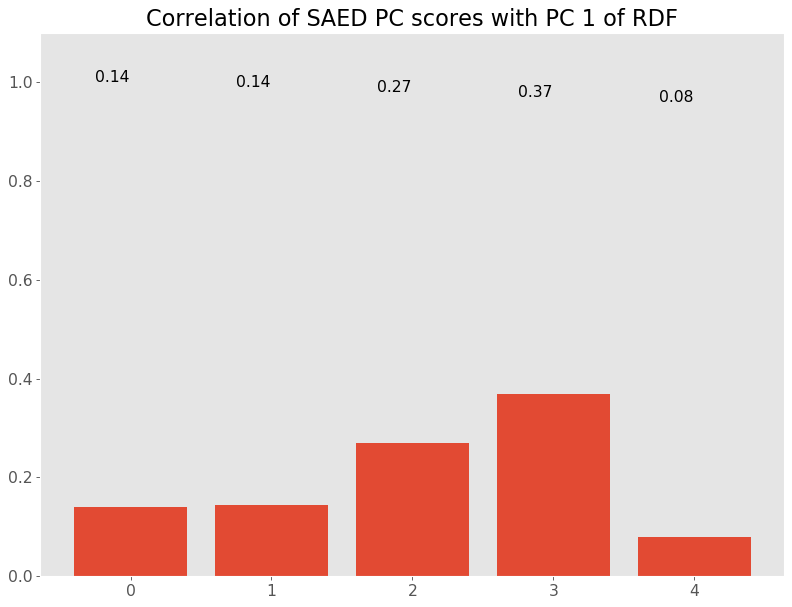

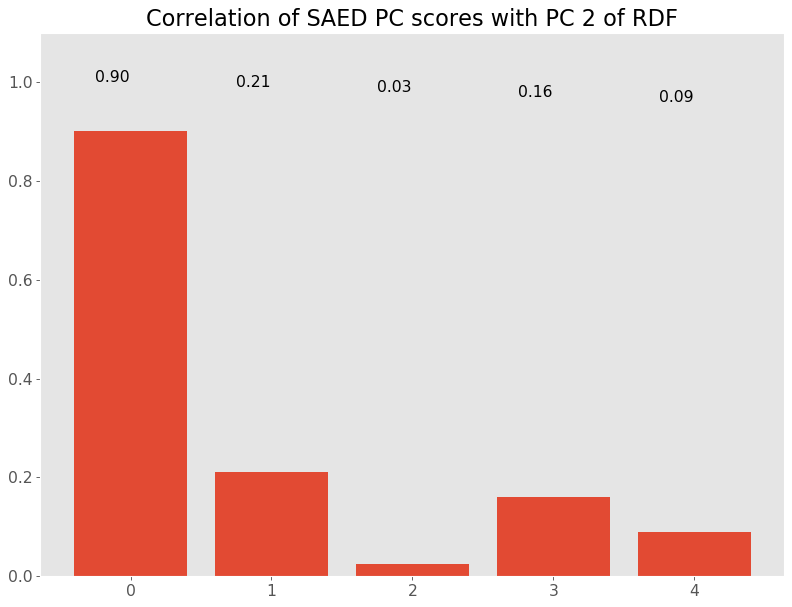

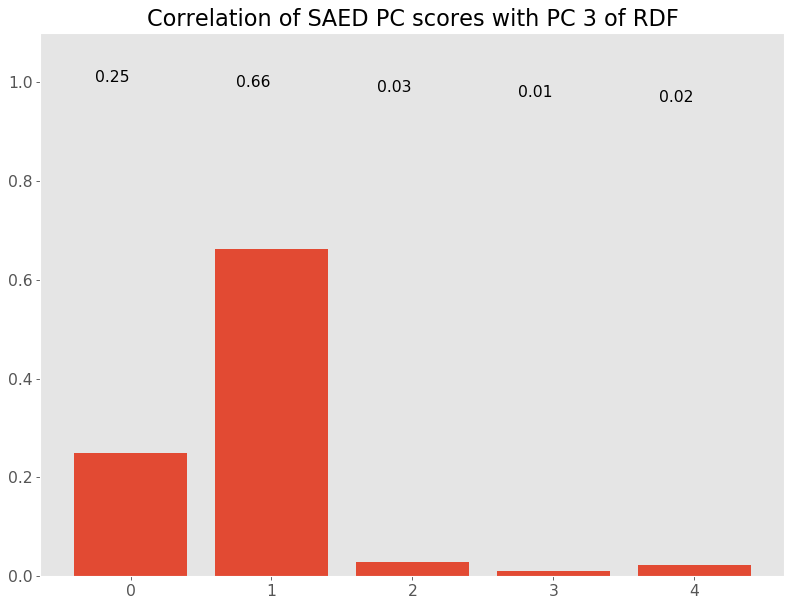

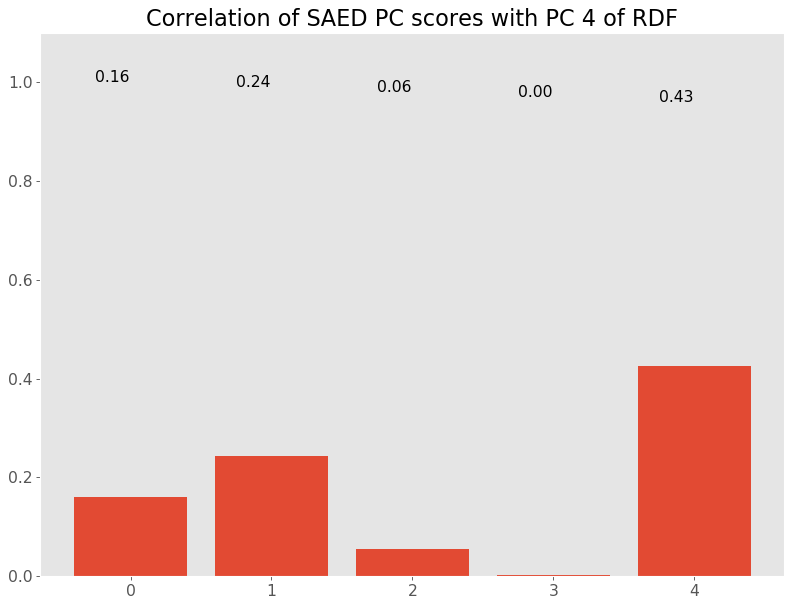

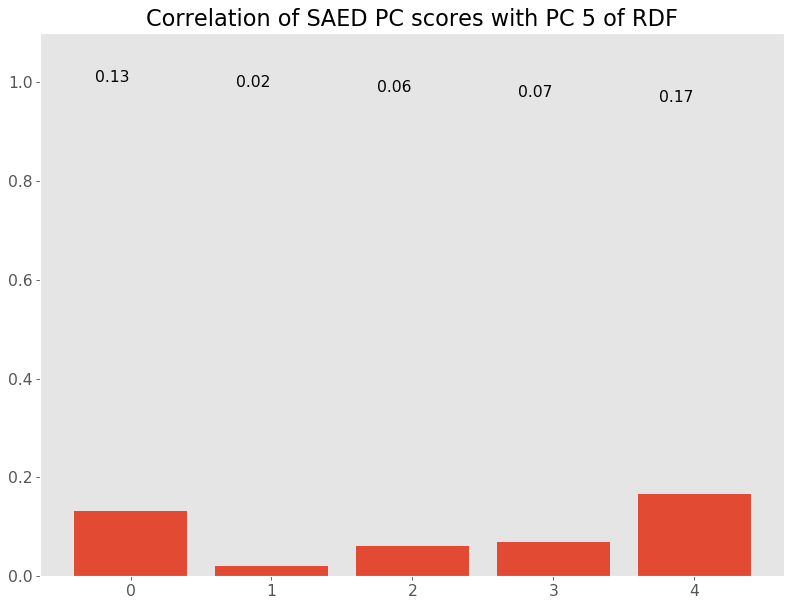

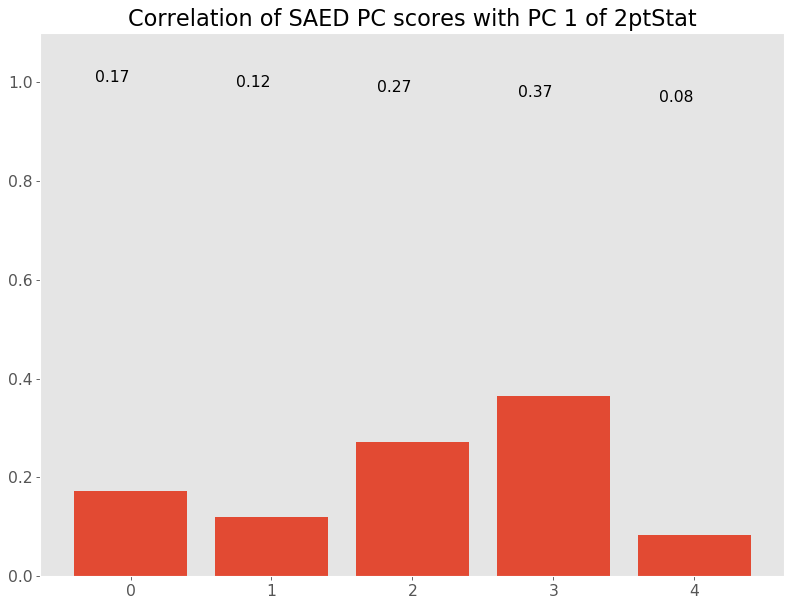

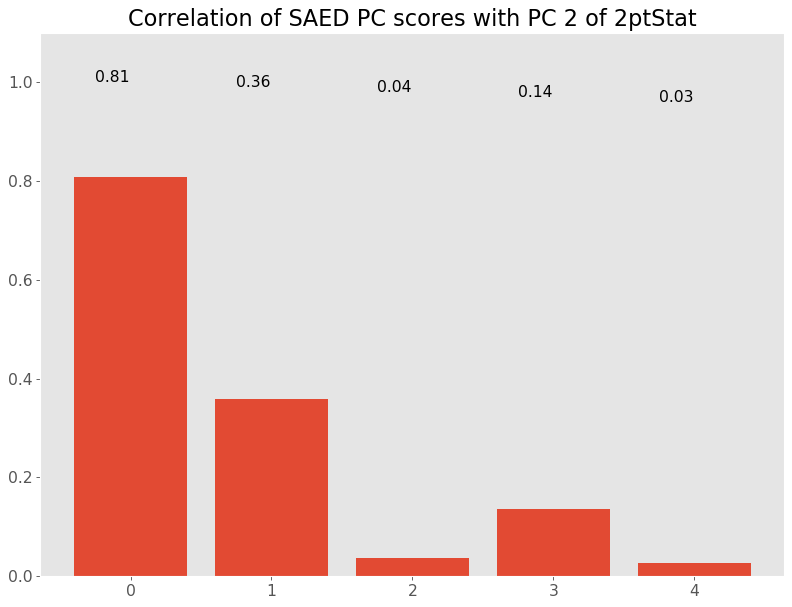

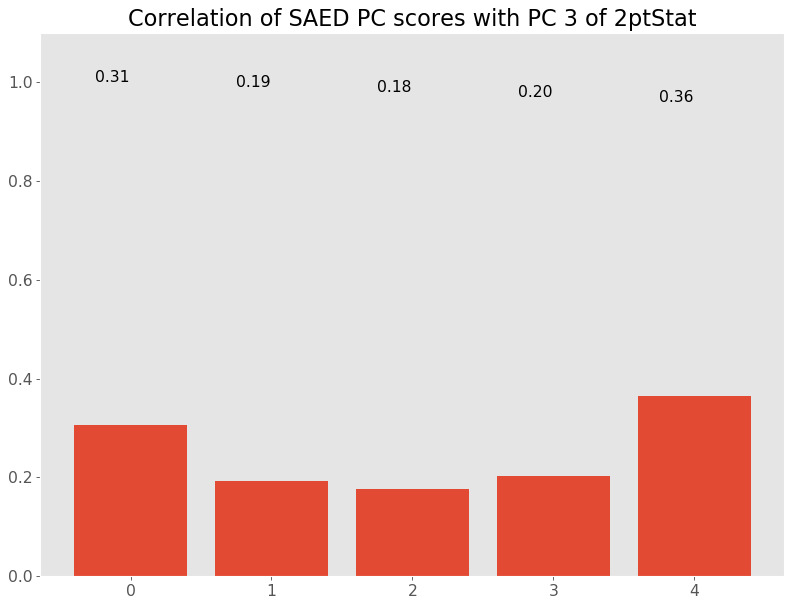

In [82]:
plot_corrs(x=scores_saed_h, y=n_atoms_irr[1:], 
           title="Correlation of SAED PC scores with no. of atoms in Cascade")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,0], 
           title="Correlation of SAED PC scores with PC 1 of RDF")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,1], 
           title="Correlation of SAED PC scores with PC 2 of RDF")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,2], 
           title="Correlation of SAED PC scores with PC 3 of RDF")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,3], 
           title="Correlation of SAED PC scores with PC 4 of RDF")

plot_corrs(x=scores_saed_h, y=scores_rdf[:,4], 
           title="Correlation of SAED PC scores with PC 5 of RDF")

plot_corrs(x=scores_saed_h, y=scores_tpt[:,0], 
           title="Correlation of SAED PC scores with PC 1 of 2ptStat")

plot_corrs(x=scores_saed_h, y=scores_tpt[:,1], 
           title="Correlation of SAED PC scores with PC 2 of 2ptStat")

plot_corrs(x=scores_saed_h, y=scores_tpt[:,2], 
           title="Correlation of SAED PC scores with PC 3 of 2ptStat")

## Spatial Moments of point defects

In [90]:
features = []
vols = []
n_atoms_all = []
n_atoms_irr = []

for run in tqdm.tqdm_notebook(runs):

    atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
             lambda f: utils.load_file(f))
    
    atoms.set_chemical_symbols(["Cu"]*len(atoms))
    indxs = np.where(atoms.get_tags() != 1)[0]

    vols.append(atoms.get_volume())
    n_atoms_all.append(len(atoms))
    n_atoms_irr.append(len(indxs))

    if len(indxs) != 0:
        coords_all = atoms.get_positions()
        coords_sub = coords_all[indxs]
        pca = PCA(n_components=3)
        scores = pca.fit_transform(coords_sub)
        m1_pca = scipy.stats.moment(scores, 1, 0)
        m2_pca = scipy.stats.moment(scores, 2, 0)
        m3_pca = scipy.stats.moment(scores, 3, 0)
        features.append(np.concatenate([np.array([n_atoms_irr[-1]]), m1_pca, m2_pca, m3_pca]))
    else:
        continue

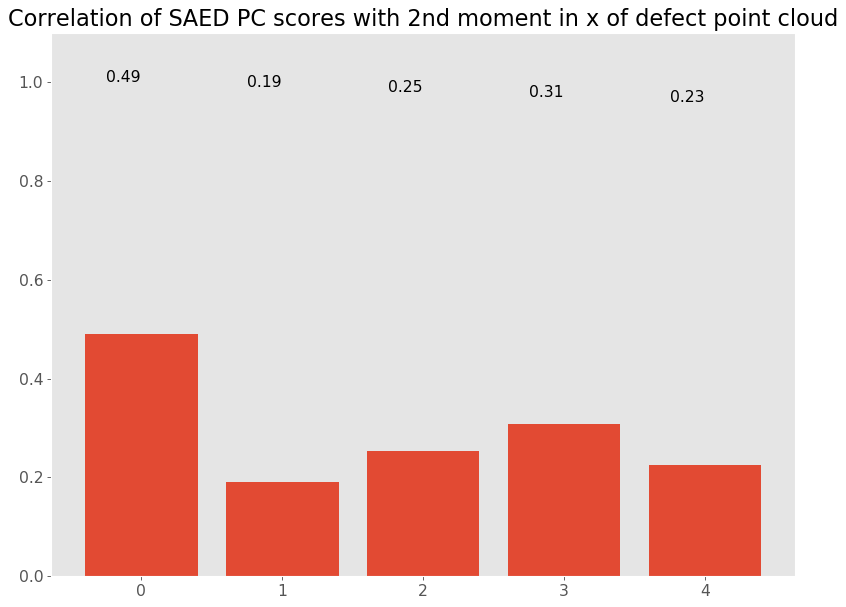

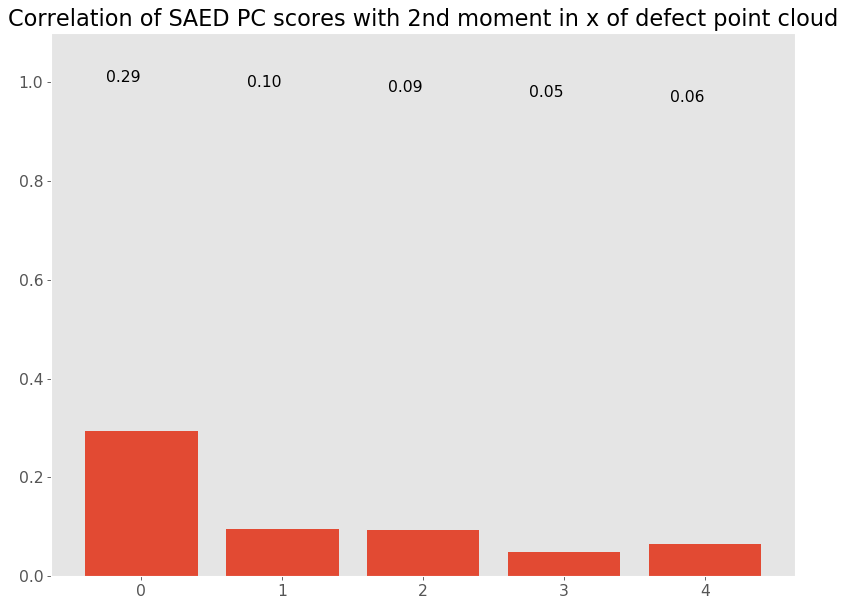

In [107]:
# plot_corrs(x=scores_saed_h, y=np.asarray(n_atoms_irr[1:])/np.asarray(n_atoms_all[1:]), 
#            title="Correlation of SAED PC scores with no. of atoms in Cascade")

plot_corrs(x=scores_saed_h, y=[f[4] for f in features], 
           title="Correlation of SAED PC scores with 2nd moment in x of defect point cloud")

plot_corrs(x=scores_saed_h, y=[f[9] for f in features], 
           title="Correlation of SAED PC scores with 2nd moment in x of defect point cloud")

In [108]:
import GPy
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, BayesianRidge

In [109]:
maerror = lambda y1, y2: np.mean(np.fabs(y1-y2))

get_rbf_kernel = curry(lambda dim, var, scl, ard: GPy.kern.RBF(input_dim=dim, 
                                                    variance=var, 
                                                    lengthscale=scl, 
                                                    ARD=ard))

@curry
def gpr_trn(x_data, y_data, scl=1.0, var=1.0, ard=True):
    
    if type(scl) is not list:
        scl = [scl] * x_data.shape[1] if ard else scl
    
    kernel = get_rbf_kernel(dim=x_data.shape[1], var=var, scl=scl, ard=ard)
    
    model = GPy.models.GPRegression(x_data, y_data, kernel)
    model.optimize();
    return model, kernel


@curry
def gpr_prd(x_data, model):
    y_prd, y_var = model.predict(x_data)
    return y_prd, np.sqrt(y_var)


@curry
def get_pca(x_data, n_comp):
    pca = PCA(n_components=n_comp)
    f_data = pca.fit(x_data)
    return pca


def get_smooth_rdf(width):
    
    rdfs = np.load("rdfs/rdf_spiky_7_200_.npy")
    
    if width > 0.0:
        bins = np.linspace(0, 7.0, rdfs.shape[1]+1)
        bin_centers = (bins[1:] + bins[:-1]) * 0.5
        kernel = epanechnikov_kernel(width=width, x=bin_centers)
        rdfs_smooth = convolve_kernel(kernel, rdfs)
        return rdfs_smooth
    else:
        return rdfs
    

@curry
def gpr_model_full(X_data, y_data, n_splits=5, n_repeats=10, seed=2652124, scl=None, var=None):

    X = X_data.copy()
    y = y_data.copy()

    rkf = RepeatedKFold(n_splits=n_splits, 
                        n_repeats=n_repeats, 
                        random_state=seed)
    
    generator = rkf.split(X)

    errs_mae = []
    errs_gpr = []

    for ix, (trn_indx, tst_indx) in enumerate(generator):

        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]

        pca = get_pca(X_trn, n_comp=15)

        transformer_x = lambda x: pca.transform(x)
        transformer_y = lambda y: y

        x_inp = transformer_x(X_trn)
        y_inp = transformer_y(y_trn)
        
        if var is None:
            var = np.var(y_inp)
            
        if scl is None:
            scl = list(np.sqrt(pca.explained_variance_))
        
        try:
            gpr, rbf = gpr_trn(x_inp, y_inp, 
                               scl=scl, 
                               var=var, 
                               ard=True)

            y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                                       gpr)

            errs_mae.append(maerror(y_prd_m, y_tst))
        except Exception as err:
            print(err)
        
    return errs_mae, errs_gpr

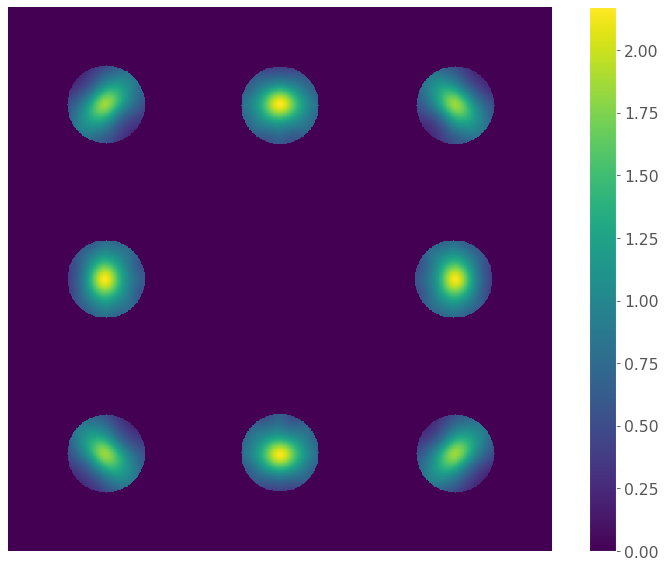

In [110]:
img_saed_list = utils.load_file("data/saed_masked_imgs_hid.pkl")
# img_saed_list = utils.load_file("data/saed_masked_imgs.pkl")
img_saed = np.concatenate([np.ravel(im)[None] for im in img_saed_list], axis=0)

plot.draw_2d(img_saed_list[0])

In [111]:
def get_model(X, y, model):
    rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
    generator = rkf.split(X)

    errs_mae = []

    for ix, (trn_indx, tst_indx) in enumerate(generator):

        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]

        model.fit(X_trn, y_trn)

        y_prd_m = model.predict(X_tst)

        y_prd_m_ = model.predict(X_trn)

        errs_mae.append(maerror(y_prd_m, y_tst))

    print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
    print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))

    lims = [min(y), max(y)]
    plt.plot(y_trn, y_prd_m_, "r*")
    plt.plot(y_tst, y_prd_m, "g*")
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    plt.tight_layout()
    plt.grid(False)
    plt.show()

test set mae: mean:5737.63543, std:915.50949
Normalized mae: 0.02104


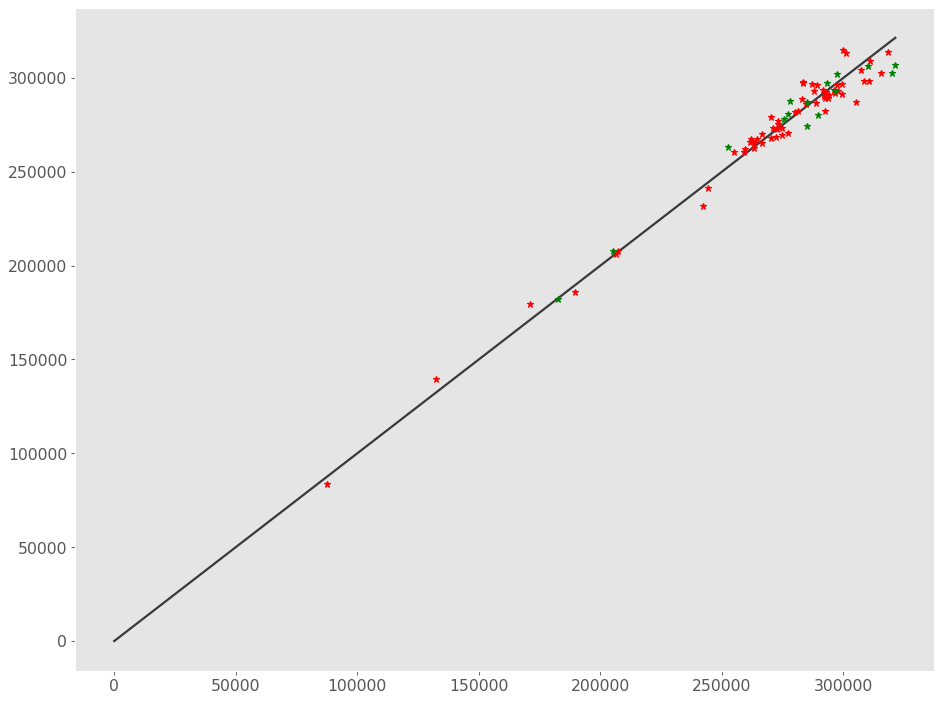

In [188]:
pca = PCA(n_components=5)
X = pca.fit_transform(img_saed_h[1:])
y = np.asarray(n_atoms_irr[1:])[...,None]
# y = np.asarray(v_mean)[...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []

for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=10.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))

lims = [0, max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.tight_layout()
plt.grid(False)
plt.show()

test set mae: mean:0.49623, std:0.08668
Normalized mae: 0.02064


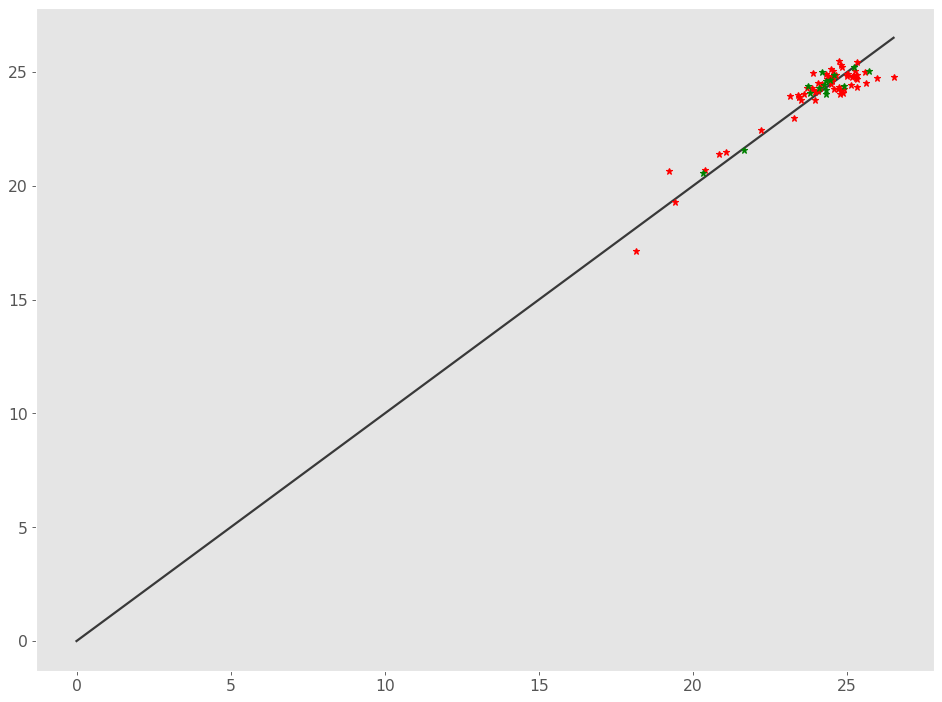

In [190]:
pca = PCA(n_components=5)
X = pca.fit_transform(img_saed_h[1:])
# y = np.asarray(n_atoms_irr[1:])[...,None]
y = np.power(np.asarray(v_mean), 0.33)[...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []

for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=10.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))

lims = [0, max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.tight_layout()
plt.grid(False)
plt.show()

test set mae: mean:1.56119, std:0.25888
Normalized mae: 0.02203


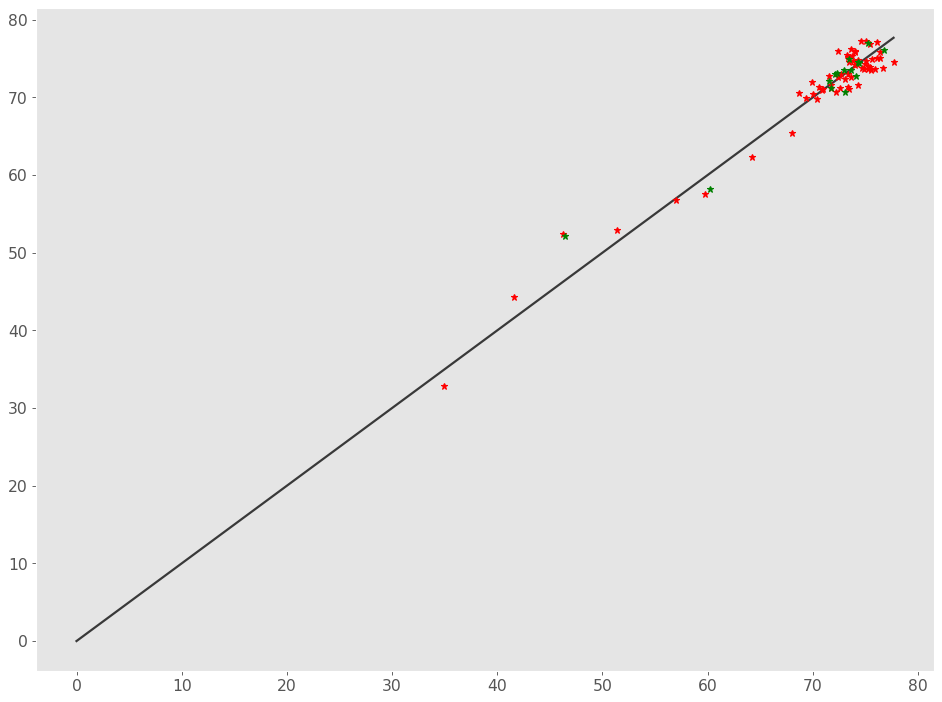

In [211]:
pca = PCA(n_components=5)
X = pca.fit_transform(img_saed_h[1:])
y = np.power(np.asarray(v_std), 0.33)[...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []

for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=10.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))

lims = [0, max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.tight_layout()
plt.grid(False)
plt.show()

test set mae: mean:24421.87099, std:5395.51459
Normalized mae: 0.05824


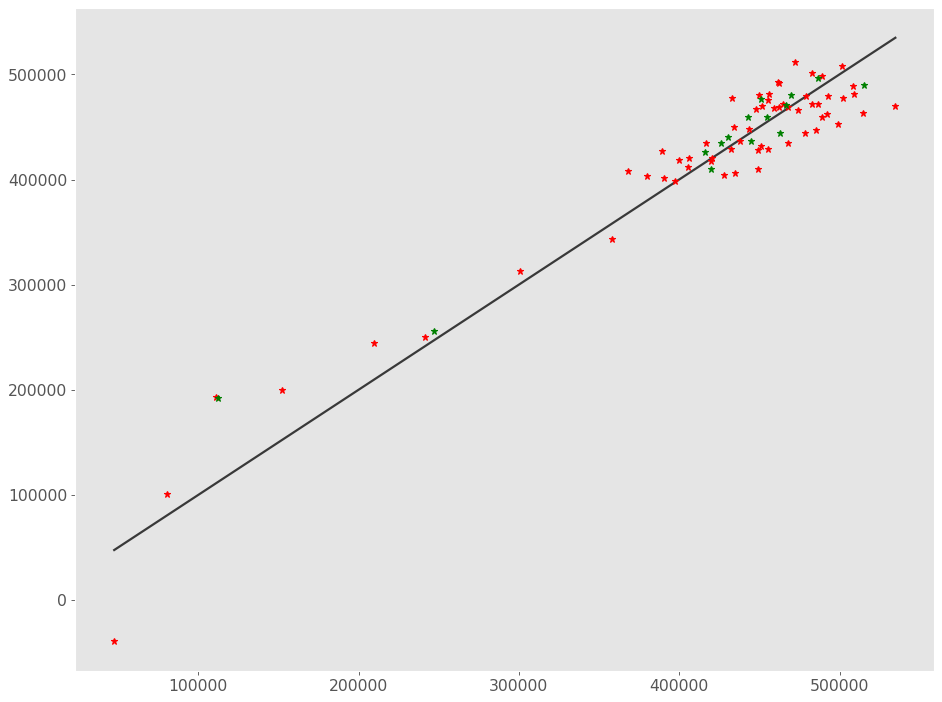

In [212]:
pca = PCA(n_components=5)
X = pca.fit_transform(img_saed_h[1:])

y = np.asarray(v_std)[...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []

for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=10.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))

lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.tight_layout()
plt.grid(False)
plt.show()

test set mae: mean:0.63608, std:0.11658
Normalized mae: 0.03951


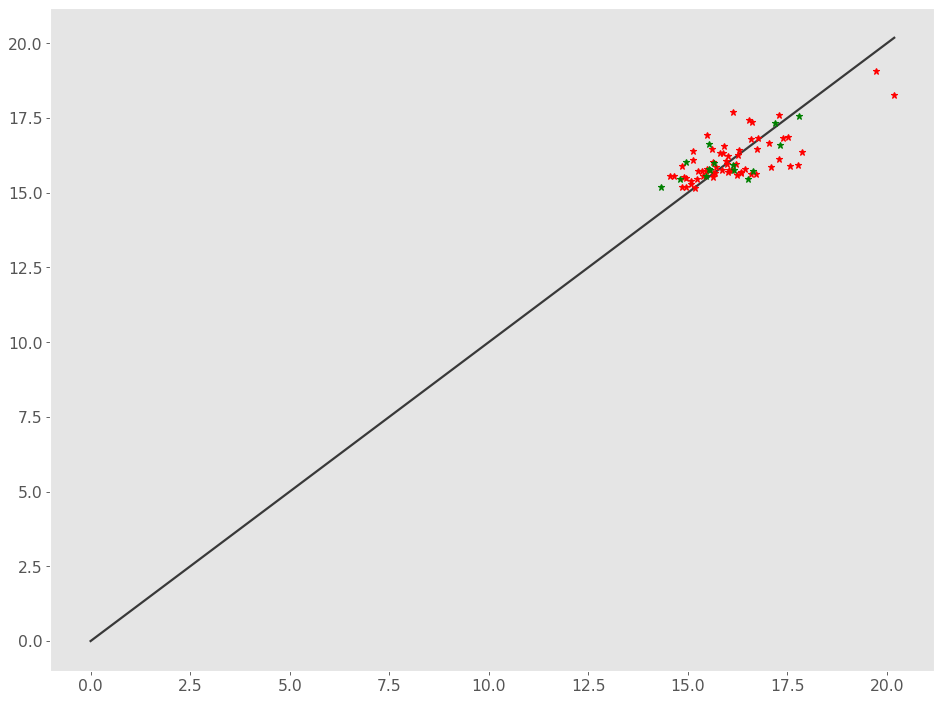

In [191]:
pca = PCA(n_components=5)
X = pca.fit_transform(img_saed_h[1:])
y = np.asarray(nn_1mean)[...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []

for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=10.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))

lims = [0, max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.tight_layout()
plt.grid(False)
plt.show()

test set mae: mean:0.85111, std:0.17300
Normalized mae: 0.03919


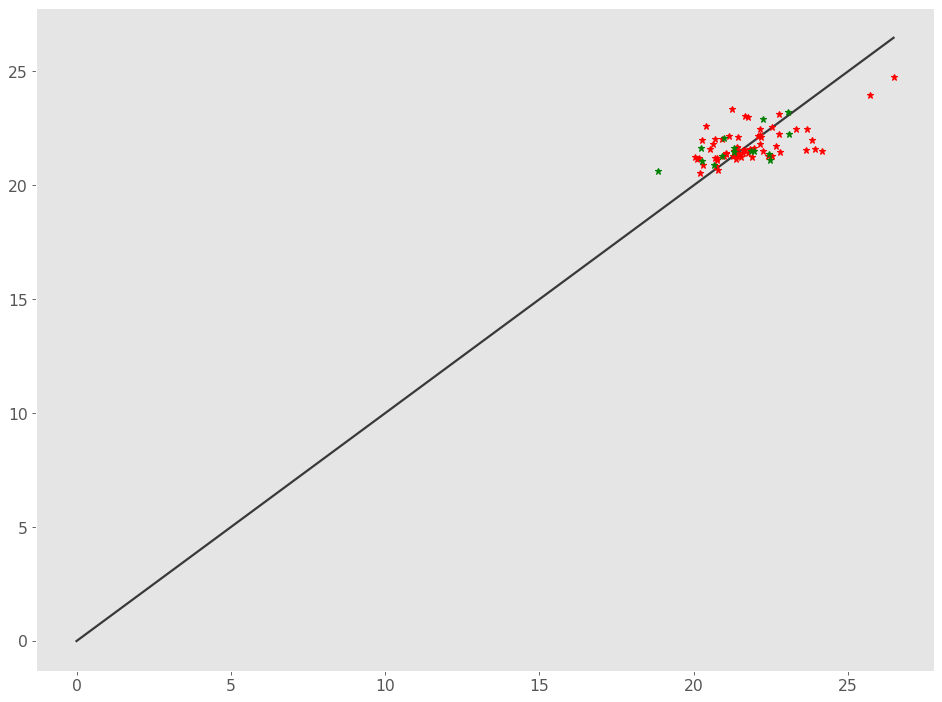

In [216]:
pca = PCA(n_components=5)
X = pca.fit_transform(img_saed_h[1:])
y = np.asarray(nn_2mean)[...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []

for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=10.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))

lims = [0, max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.tight_layout()
plt.grid(False)
plt.show()

test set mae: mean:997.34678, std:180.15798
Normalized mae: 0.06437


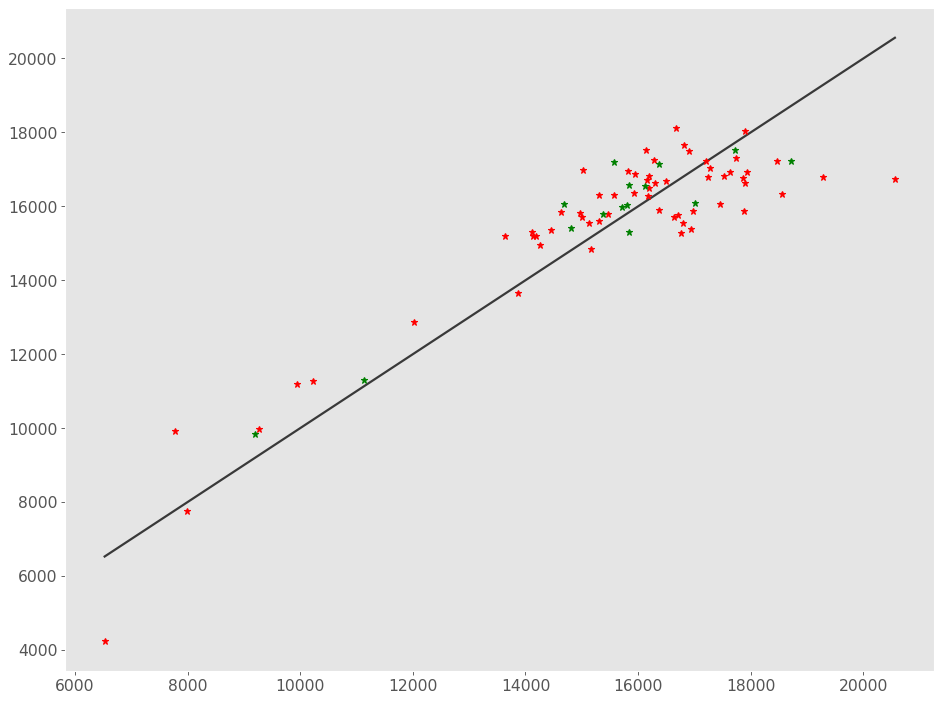

In [201]:
pca = PCA(n_components=5)
X = pca.fit_transform(img_saed_h[1:])
y = np.asarray(v_mean)[...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []

for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=10.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))

# lims = [0, max(y)]
lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.tight_layout()
plt.grid(False)
plt.show()

test set mae: mean:0.42782, std:0.09286
Normalized mae: 0.41415


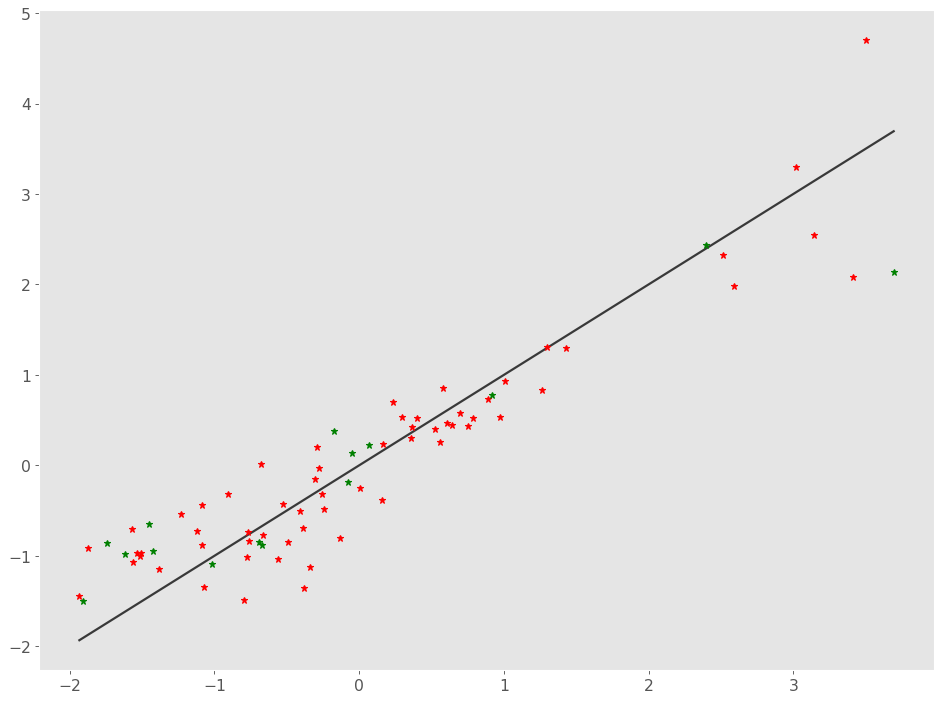

In [209]:
X = scores_saed_h[:,:5]
y = scores_rdf[:,0]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []

for ix, (trn_indx, tst_indx) in enumerate(generator):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]
    
    model = Ridge(alpha=1.0)
    model.fit(X_trn, y_trn)
    
    y_prd_m = model.predict(X_tst)

    y_prd_m_ = model.predict(X_trn)

    errs_mae.append(maerror(y_prd_m, y_tst))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(np.fabs(y))))

lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.tight_layout()
plt.grid(False)
plt.show()

 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide



test set mae: mean:1.99823, std:0.54671
Normalized mae: 0.91206


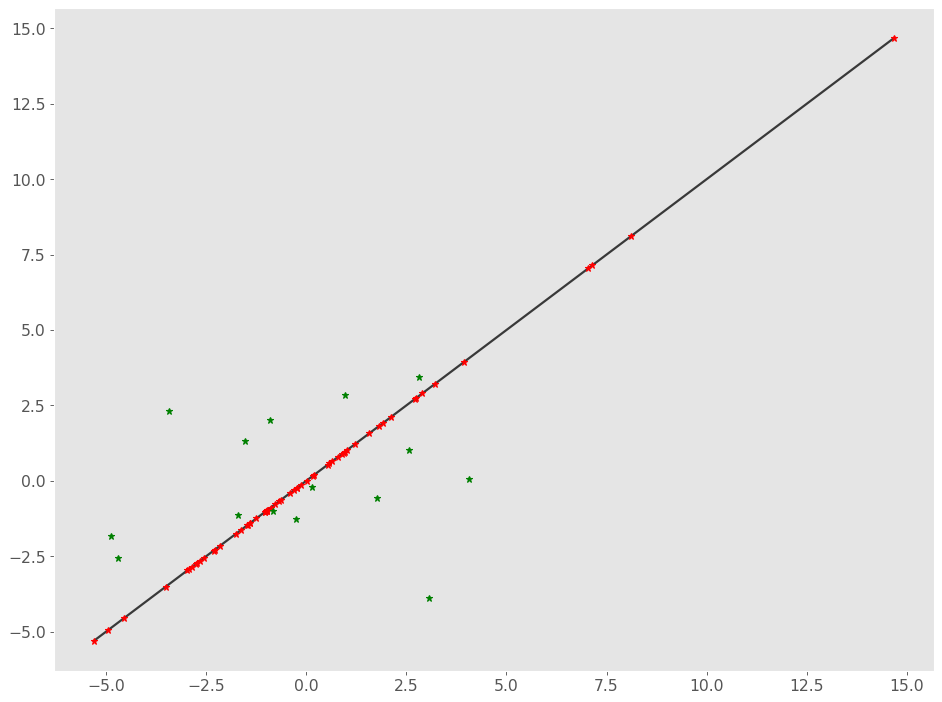

In [72]:
X = scores_saed_h
y = scores_rdf[:,0][...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
generator = rkf.split(X)

errs_mae = []
errs_gpr = []

for ix, (trn_indx, tst_indx) in enumerate(tqdm.tqdm_notebook(generator)):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]


    transformer_x = lambda x: x
    transformer_y = lambda y: y

    x_inp = transformer_x(X_trn)
    y_inp = transformer_y(y_trn)

    gpr, rbf = gpr_trn(x_inp, y_inp, 
                       scl=[1.0]*X.shape[1], 
                       var=np.var(y_trn), 
                       ard=True)

    y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                               gpr)

    y_prd_m_, _ = gpr_prd(transformer_x(X_trn), 
                               gpr)

    errs_mae.append(maerror(y_prd_m, y_tst))
    errs_gpr.append(np.mean(y_prd_s))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(np.fabs(y))))


lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

# plt.xlim(lims)
# plt.ylim(lims)
plt.tight_layout()
plt.grid(False)
plt.show()

 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide



test set mae: mean:2.06258, std:0.42601
Normalized mae: 0.48825


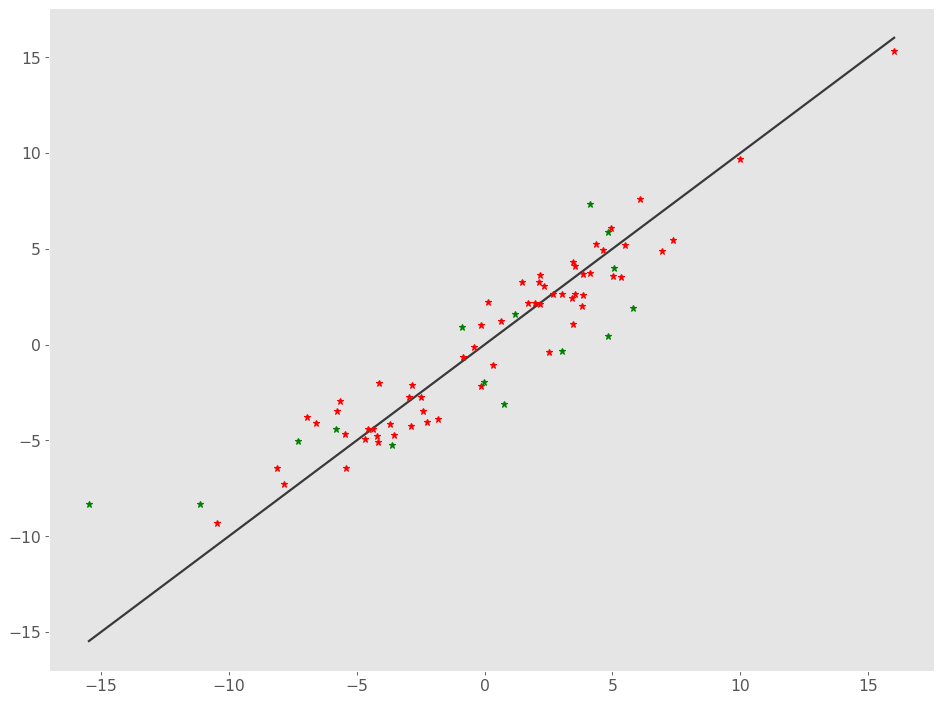

In [208]:
X = scores_saed_h
y = scores_rdf[:,0][...,None]

rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)
generator = rkf.split(X)

errs_mae = []
errs_gpr = []

for ix, (trn_indx, tst_indx) in enumerate(tqdm.tqdm_notebook(generator)):

    X_trn, X_tst = X[trn_indx], X[tst_indx]
    y_trn, y_tst = y[trn_indx], y[tst_indx]


    transformer_x = lambda x: x
    transformer_y = lambda y: y

    x_inp = transformer_x(X_trn)
    y_inp = transformer_y(y_trn)

    gpr, rbf = gpr_trn(x_inp, y_inp, 
                       scl=[1.0]*X.shape[1], 
                       var=np.var(y_trn), 
                       ard=True)

    y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                               gpr)

    y_prd_m_, _ = gpr_prd(transformer_x(X_trn), 
                               gpr)

    errs_mae.append(maerror(y_prd_m, y_tst))
    errs_gpr.append(np.mean(y_prd_s))

print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(np.fabs(y))))


lims = [min(y), max(y)]
plt.plot(y_trn, y_prd_m_, "r*")
plt.plot(y_tst, y_prd_m, "g*")
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

# plt.xlim(lims)
# plt.ylim(lims)
plt.tight_layout()
plt.grid(False)
plt.show()